In [9]:
from humanBanditFunctions import *
# from regressionFunctions import *
from supplementaryFunctions import *
from scipy.stats import entropy

# build a dict of files with participant numbers as key and participant df as value (concatenated and corrected)
'''ideally, it would be better if it can catch filenames that are giving errors on its own'''

exclusions = ['7_bandit_expt_2022-11-27_12h19.09.803.csv', '7_bandit_expt_unstr_2022-11-25_17h40.21.269.csv',
              '7_bandit_expt_unstr_2022-11-24_20h34.47.816.csv','8_bandit_expt_unstr_2022-11-22_20h26.45.589.csv']
full_dict = construct_dict(exclusions)
str_dict = construct_dict(exclusions, 'str')
unstr_dict = construct_dict(exclusions, 'unstr')
dataset = pd.DataFrame()
for participant in full_dict.keys():
    full_dict[participant]['valid'] = full_dict[participant]['status']
    full_dict[participant]['valid'] = full_dict[participant]['valid'].replace({np.nan: 'bad'})
    full_dict[participant] = full_dict[participant].ffill()
    full_dict[participant] = full_dict[participant][full_dict[participant]['valid']!='bad'].sort_values(by = ['session', 'trials.thisN']).drop_duplicates()
    dataset = pd.concat([dataset, full_dict[participant]], ignore_index = True)
dataset['key_resp.keys'] = pd.Categorical(dataset['key_resp.keys'], list('asdfhjkl'))
dataset['trials.thisN'] = dataset['trials.thisN'].astype(int)
dataset['task'] = np.nan
dataset['task'].loc[dataset.session>5] = 'str'
dataset['task'].loc[dataset.session<=5] = 'unstr'
dataset['shuffled'] = dataset.shuffled.apply(lambda x: x.translate({ord(i): None for i in '[] '})
                                                                    .replace('.0', '')
                                                                    .split(','))
dataset['shuffled'] = dataset.shuffled.apply(lambda x: np.array(x, dtype = float))
l=[]
key_dict = {'a':1, 's':2, 'd':3, 'f':4, 'h':5, 'j':6, 'k':7, 'l':8}
dataset['key_resp.keys'] = dataset['key_resp.keys'].replace(key_dict)

dataset['choice_t1'] = (dataset.groupby(['participant','session'])['key_resp.keys'].shift(-1))
dataset['choice_t2'] = (dataset.groupby(['participant','session'])['key_resp.keys'].shift(-2))
dataset['shift_t0'] = (dataset['choice_t1']==dataset['key_resp.keys']).replace({True: 0, False: 1})
dataset['shift_t1'] = (dataset['choice_t2']==dataset['key_resp.keys']).replace({True: 0, False: 1})
for ind, i in enumerate(dataset.shuffled.apply(lambda x: np.array(x, dtype = float))):
    l.append(i[dataset['key_resp.keys'][ind].astype(int)-1])
dataset['rewprob'] = l
dataset['rewprob'] = (dataset['rewprob']*100).astype(int)
window = 5
dataset['regret'] = abs(dataset['rewprob'] - 80)
dataset['status'] = dataset['status'].astype(int)
dataset['entropy'] = (dataset.groupby(['participant', 'session'], as_index = False)['key_resp.keys']
                     .rolling(window, center=True)
                     .apply(lambda x: entropy(calc_prob(x), base = 2))['key_resp.keys'])
print('All packages and data loaded successfully')

C:\Users\dlab\AppData\Local\Temp\ipykernel_16128\2004781485.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['task'].loc[dataset.session>5] = 'str'


All packages and data loaded successfully


In [12]:
dataset.columns

Index(['sess_mean', 'rew_val', 'shuffled', 'participant', 'session',
       'key_resp.keys', 'key_resp.rt', 'status', 'trials.thisN', 'valid',
       'task', 'rewprob', 'entropy'],
      dtype='object')

In [75]:
# %matplotlib nbagg
%matplotlib inline
import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle
# import matplotlib.pyplot as plt
# import seaborn as sns
participant = 8

# Create a function to update the plot based on user input
def update_plot(session_range):
    dataset_filtered = dataset[(dataset['session'].between(*session_range))& (dataset.participant ==participant)]
    markers = {0: "$o$", 1: "o"}
#     markers = {0: 2, 1:3}
#     fig = plt.figure(figsize=(15, 8))
    g = sns.relplot(data=dataset_filtered, y='key_resp.keys', x=dataset_filtered.index, 
                    hue='rewprob',
                    aspect=11.7/5.5,
                    linewidth=0, s=100, palette = 'Blues', marker = '.',
#                     markers=markers, style='status',
                    hue_norm=(-20, 80))
    axes = g.axes.flatten()
#     last = dataset.groupby('session').index.max().to_list()
#     start = dataset.groupby('session').index.min().to_list()
    last = dataset_filtered[dataset_filtered['trials.thisN']==39].index.to_list()
    start = dataset_filtered[dataset_filtered['trials.thisN']==0].index.to_list()
#     highport = [ind+1 for i in dataset_filtered.groupby('session').head(1).shuffled for ind, j in enumerate(i) if j*100==80]
#     print(highport)
    for ax in axes:
        for ind, l in enumerate(last):
            ax.axvline(l, linewidth=1, color='grey')
#             ax.axvline(, linewidth = 1, color = 'red')
#             ax.set_yticks([1, 2, 3, 4, 5, 6, 7,8])
#             ax.add_patch(Rectangle((start[ind]-1, highport[ind]-0.5), l-start[ind], 1, fc = 'xkcd:blue', alpha = 0.1))
    
    plt.ylim(0.5, 8.5)
    plt.title('Choices', y=1.05)
    g._legend.set_title('Rew. %')
#     g._legend.texts[0].set_text("Reward %")
#     g._legend.texts[5].set_text("Outcome")
#     plt.xticks(ticks = [], labels = [])

    plt.xlabel(' ', labelpad=20)
    plt.ylabel('Port')
    
    # Calculate x-axis limits based on the displayed sessions
    x_limit = (dataset_filtered.index.min(), dataset_filtered.index.max())
    plt.xlim(*x_limit)
    sns.despine(bottom = True)
#     plt.savefig('C:/Users/dlab/OneDrive - Indian Institute of Science/Drawings/grc/eg_human.svg', dpi = 600)
    plt.show()

# Define the session range using a widget
session_range_slider = widgets.IntRangeSlider(
    value=[dataset['session'].min(), dataset['session'].max()],
    min=dataset['session'].min(),
    max=dataset['session'].max(),
    step=1,
    description='Session Range:',
    continuous_update=False
)

# # Create an interactive plot using interactive
interactive_plot = widgets.interactive(update_plot, session_range=session_range_slider)

# Display the interactive plot
display(interactive_plot)
# plt.xticks(ticks = [], labels = [])
# plt.tight_layout()
# sns.set_context('talk')
# plt.title('Blissey - DLS then DMS lesion')

interactive(children=(IntRangeSlider(value=(2, 9), continuous_update=False, description='Session Range:', max=…

In [90]:
np.unique(np.vstack(dataset[dataset.participant==8].shuffled).astype(float), axis = 0)*100

array([[10.19611466, 15.1358756 , 11.18159189, 10.00202845, 69.45560716,
        26.10464093, 46.43150847, 10.02348238],
       [15.1358756 , 26.10464093, 46.43150847, 69.45560716, 80.        ,
        69.45560716, 46.43150847, 26.10464093],
       [26.10464093, 46.43150847, 69.45560716, 80.        , 69.45560716,
        46.43150847, 26.10464093, 15.1358756 ],
       [46.43150847, 69.45560716, 80.        , 69.45560716, 46.43150847,
        26.10464093, 15.1358756 , 11.18159189],
       [69.45560716, 11.18159189, 80.        , 26.10464093, 46.43150847,
        10.19611466, 15.1358756 , 10.02348238],
       [69.45560716, 80.        , 69.45560716, 46.43150847, 26.10464093,
        15.1358756 , 11.18159189, 10.19611466],
       [80.        , 69.45560716, 46.43150847, 26.10464093, 15.1358756 ,
        11.18159189, 10.19611466, 10.02348238]])

### Choice bias identification
Line = sum of all probabilities for all sessions (both structured and unstructured)<br>
Histogram = sum of all arms chosen

In [9]:
#     correct data - remove extra apostrophes, split as lists, reshape into actual array
def session_wise_prob(df):
    raw_prob_arms = df[df['participant']==participant]['shuffled'].dropna()
    corrected_arr = []
    for j in raw_prob_arms:
        temp = j.strip('[]').split(',')
        corrected_val = []
        for i in temp:
            corrected_val.append(float(i))
        corrected_arr.append(corrected_val)
    return corrected_arr 

#     Dictionary for chosen arms (participant, session wise)
def chosen_arm(full_dict):
    chosen_arm_dict = {}
    for participant, df in full_dict.items():
        choices = 'asdfhjkl'
        arms = len(choices)
        
    #     assign value (0-7) to key inputs
        chosen_arm = []
        for i in df['key_resp.keys'][df['key_resp.keys'].notna()]:
            chosen_arm.append(choices.index(i))
        chosen_arm_dict[participant] = chosen_arm
    return chosen_arm_dict

def actual_prob(full_dict):
#     Dictionary for actual probability of arms (participant, session wise)
    correct_prob_dict = {}
    temp = 0
    for participant, df in full_dict.items():
        sessions = df[df['participant']==participant]['session'].sort_values().dropna().unique()
        for ses in sessions:
            sessions_prob = []
            sessions_prob.append(session_wise_prob(df))
        correct_prob_dict[participant] = sessions_prob[0]

    mean_prob_arr = np.zeros(8)

    for participant, sess_prob_arr in correct_prob_dict.items():
        temp += np.mean(sess_prob_arr, axis = 0)
    mean_prob_arr = temp/participant 
    return correct_prob_dict, mean_prob_arr

def reward_hist(full_dict):
    reward_dict = {}
    for participant, df in full_dict.items():
        print(participant)
        sessions = df['session'].sort_values().dropna().unique()
        print(sessions)
        trials = df['trials.thisN'].sort_values().dropna().unique()
        reward = np.zeros((len(sessions), len(trials)))
        for ses in sessions:
            for trial in trials:
                if df[(df['session']==ses) & (df['trials.thisN']==trial)]['status'].item()==True:
                    reward[np.where(sessions == ses)[0][0], np.where(trials == trial)[0][0]] = 1
                else:
                    reward[np.where(sessions == ses)[0][0], np.where(trials == trial)[0][0]] = 0
        reward_dict[participant] = reward
    print('Reward dictionary created')
    return reward_dict

def calc_prob(pk):
    # calc prob of actions
    unique, counts = np.unique(np.array(pk), return_counts =True)
    outcomes = len(pk)
    return counts/outcomes

chosen_arm_dict = chosen_arm(full_dict)
str_chosen_arm_dict = chosen_arm(str_dict)
unstr_chosen_arm_dict = chosen_arm(unstr_dict)
reward_dict = reward_hist(full_dict)
str_reward_dict = reward_hist(str_dict)
unstr_reward_dict = reward_hist(unstr_dict)

1
[2 3 4 5 6 7 8 9]
2
[2 3 4 5 6 7 8 9]
3
[2 3 4 5 6 7 8 9]
4
[2 3 4 5 6 7 8 9]
5
[2 3 4 5 6 7 8 9]
6
[2 3 4 5 6 7 8 9]
7
[2 3 6 8 9]
8
[3 4 5 6 7 8 9]
9
[2 3 4 5 6 7 8 9]
Reward dictionary created
1
[6 7 8 9]
2
[6 7 8 9]
3
[6 7 8 9]
4
[6 7 8 9]
5
[6 7 8 9]
6
[6 7 8 9]
7
[6 8 9]
8
[5 6 7 8 9]
9
[6 7 8 9]
Reward dictionary created
1
[2 3 4 5]
2
[2 3 4 5]
3
[2 3 4 5]
4
[2 3 4 5]
5
[2 3 4 5]
6
[2 3 4 5]
7
[2 3]
8
[3 4]
9
[2 3 4 5]
Reward dictionary created


C:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


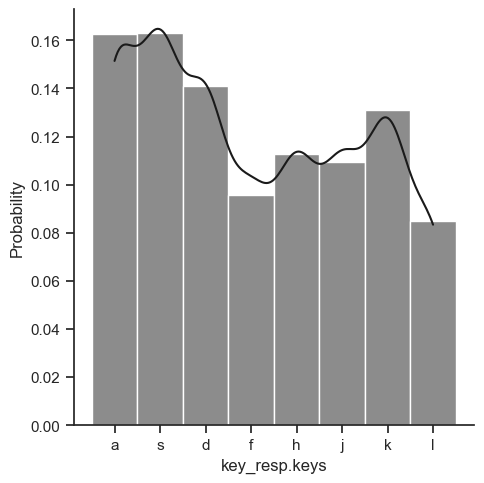

In [8]:
#    plot total counts of each arm, normalized
sns.displot(data = dataset, x = 'key_resp.keys', stat = 'probability', color = 'k', kde = 'True')
sns.despine()

In [ ]:
# Participant wise histograms
sns.displot(data = dataset, col = 'participant', col_wrap = 5, x = 'key_resp.keys',
            stat = 'probability', kde = True, color = 'k')
plt.suptitle('Participant choices, all sessions', fontsize=16)
plt.tight_layout()
# plt.savefig('plots/prob_choosing_arms.png', dpi = 300)

# Regret
Abolute(Optimal armprob - chosen arm prob)

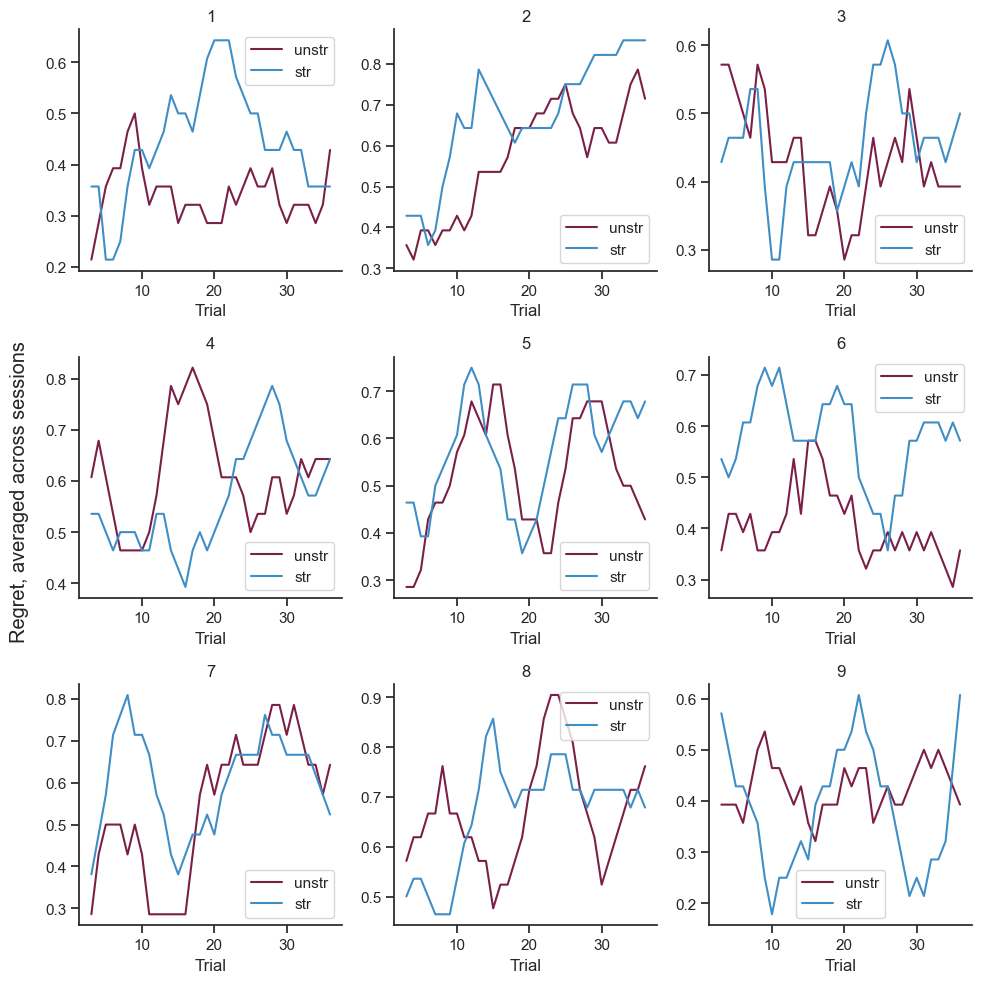

In [10]:
#################################### regret ######################################
window = 7
trialsinsess = 40
fig = plt.figure(figsize=(10,10))
# sessdf['regret'] = 1-(abs(sessdf['rewprob'] - 80)/100)
dataset['regret'] = abs(dataset['rewprob'] - 80)
dataset['rr'] = dataset.groupby(['participant', 'session'], as_index = False).status.rolling(window, center=True).mean().status

reg_mean_dict = {}
# rem_les = sessdf[~(sessdf.task.isin(['dms', 'dls', 'sham']))]

colors ={'str':'#408ec6', 'unstr':'#7a2048'} 
for i in ['unstr', 'str']:

    for ind, (p, group) in enumerate(dataset.groupby('participant')):
        ax = plt.subplot(3, 3, ind+1)

        # filter by sessions>= length
        group = (group[group.task.isin([i])])

        # convert to numpy array
        g = group.groupby('session').cumcount()
        L = np.array(group.set_index(['session',g])
               .unstack(fill_value=0)
               .stack().groupby(level=0)
               .apply(lambda x: x.rr.values.tolist())
               .tolist())

        # mean
        reg_mean = np.mean(L, axis=0)
        reg_mean_dict[p, i] = reg_mean
        ax.plot(reg_mean, label = i, c = colors[i])
        ax.set_title(p)
        ax.legend()
        ax.set_xlabel('Trial')

sns.despine()
fig.supylabel('Regret, averaged across sessions')
plt.tight_layout()

In [21]:
from scipy.stats import sem
plt.figure(figsize = (5,4.5))

%matplotlib qt
color1 = 'xkcd:pumpkin orange'
color2 = 'xkcd:emerald green'

temp_unstr, temp_str = [], []
for (p, env) in reg_mean_dict.keys():
    if env == 'unstr':
        temp_unstr.append(reg_mean_dict[(p, env)])
    elif env=='str':
        temp_str.append(reg_mean_dict[(p, env)])
# temp_unstr = (1-np.array(temp_unstr)/100)
# temp_str = (1-np.array(temp_str)/100)
temp_unstr = np.array(temp_unstr)
temp_str = np.array(temp_str)

# for i, row in enumerate(temp_unstr):
#     temp_unstr[i] = np.convolve(row, np.ones(3)/3, 'same')
#     temp_str[i] = np.convolve(temp_str[i], np.ones(3)/3, 'same')

# temp_unstr = temp_unstr[:, 1:39]
# temp_str = temp_str[:, 1:39]

mean_unstr = np.mean(temp_unstr, axis =0)
mean_str = np.mean(temp_str, axis =0)

plt.plot(np.arange(0,40), mean_str, color2, label = 'Structured')
plt.plot(np.arange(0,40), mean_unstr, color1 , label = 'Unstructured')
plt.fill_between(np.arange(0, 40),mean_unstr+sem(temp_unstr), mean_unstr-sem(temp_unstr), color = color1, alpha = 0.2)
plt.fill_between(np.arange(0, 40),mean_str+sem(temp_str), mean_str-sem(temp_str), color = color2, alpha = 0.2)
# plt.title('Task performance')
plt.xlabel('Trials', fontsize = 'x-large')
plt.ylabel('Performance index', fontsize = 'x-large')
# plt.ylim(0.6, 0.90)
plt.xlim(0,40)
# plt.axhline(0.625, color='k', linestyle = '--') # chance calc by/
# ((1-(80-(np.mean(np.array([80, 46, 46, 15]))))/100)+(1-(80-(np.mean(np.array([80, 46, 10, 15]))))/100))/2
plt.xticks([0,10, 20, 30, 40], [1, '', '', '',  40], fontsize = 'large', color = 'grey')
# plt.yticks([0.6, 0.7, 0.8, 0.9], [0.6, '','', 0.9], fontsize = 'large', color = 'grey')
sns.despine(trim = True)
plt.legend(loc = 'upper right')#, bbox_to_anchor=(1.0, 0.4))
plt.tight_layout()


C:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\ipykernel\eventloops.py:145: UserWarning: The figure layout has changed to tight
  el.exec() if hasattr(el, "exec") else el.exec_()


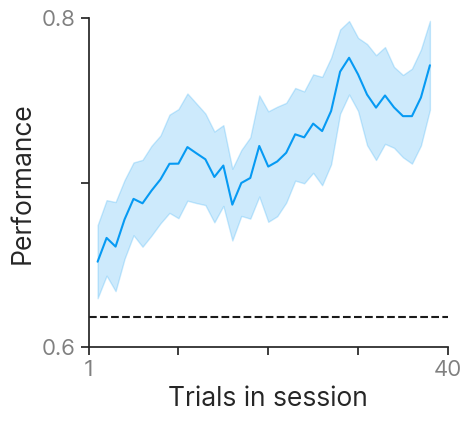

In [19]:
from matplotlib import font_manager
font_path = 'C:/Windows/Fonts/Inter-Regular.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['font.size'] = 16
temp_reg = np.array([i for i in reg_mean_dict.values()])
plt.figure(figsize = (5,4.5))

temp_reg = (1-np.array(temp_reg)/100)

for i, row in enumerate(temp_reg):
    temp_reg[i] = np.convolve(row, np.ones(3)/3, 'same')

temp_reg = temp_reg[:, 1:39]

mean_reg = np.mean(temp_reg, axis =0)

plt.plot(np.arange(1,39),mean_reg, 'xkcd:azure')

plt.fill_between(np.arange(1, 39),mean_reg+sem(temp_reg), mean_reg-sem(temp_reg), color = 'xkcd:azure', alpha = 0.2)
plt.axhline(0.6186, linestyle = '--', color = 'k')
plt.xlabel('Trials in session', fontsize = 'large')
plt.ylabel('Performance', fontsize = 'large')
plt.ylim(0.6, 0.80)
plt.xlim(0,40)
plt.xticks([0,10, 20, 30, 40], [1, '', '', '',  40], color = 'grey', fontsize = 'medium')
plt.yticks([0.6, 0.7, 0.8], [0.6, '',0.8], color = 'grey', fontsize = 'medium')
sns.despine(trim = True)
plt.tight_layout()
#######chance calc
def fxn(mean, arms):
    x = np.linspace(1, arms, arms)
    sig = 1.75
#     amp = 1/(sig*np.sqrt(2*np.pi))
    amp = 0.7
    vo = 0.1
    gx = (amp*np.exp(-0.5*((x-mean)**2)/(sig**2)))+vo
#     gx = np.random.permutation(gx)
    return gx
1-((0.8-np.mean(fxn(1,8)))+(0.8-np.mean(fxn(2,8)))+(0.8-np.mean(fxn(3,8)))+(0.8-np.mean(fxn(4,8))))/4
plt.savefig('C:/Users/dlab/OneDrive - Indian Institute of Science/Drawings/awp1/ppthumanperf.png', dpi = 300)

In [11]:
mean_reg

array([0.65197531, 0.66641975, 0.66114198, 0.67765432, 0.69013889,
       0.68743827, 0.69512346, 0.70195988, 0.71145062, 0.71152778,
       0.72158951, 0.71782407, 0.71416667, 0.70344136, 0.71037037,
       0.68662037, 0.69978395, 0.70282407, 0.72226852, 0.70975309,
       0.71285494, 0.71814815, 0.72935185, 0.7275    , 0.73584877,
       0.73131173, 0.74351852, 0.76740741, 0.77584877, 0.76574074,
       0.75348765, 0.74555556, 0.75294753, 0.74572531, 0.7403858 ,
       0.7403858 , 0.75169753, 0.77128086])

In [292]:
from scipy.stats import ttest_rel
t, p=ttest_rel(mean_str, mean_unstr)
# len([i for k, i in enumerate(p) if (i<0.05)])
print(p)

9.443323979872536e-10


# Deviation from simulated data

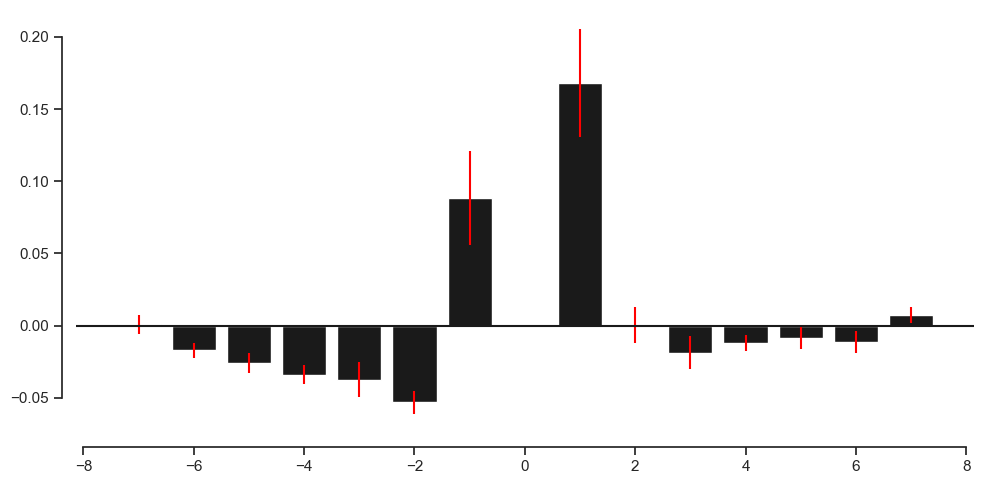

In [13]:
%matplotlib inline
# trialsinsess = 100

# sim_qldf = pd.read_csv('L:/4portProb_processed/sim_qldf.csv')
# sim_qldf.drop(columns = 'Unnamed: 0', inplace = True)
# sim_qldf['reward'] = sim_qldf.reward.replace({-1:0})
# sessdf['backchoice_t1'] = sessdf.groupby(['animal','session#']).port.shift(1)
# sim_qldf['backchoice_t1'] = sim_qldf.groupby(['animal','session#']).port.shift(1)
# sim_qldf['choice_t1'] = sim_qldf.groupby(['animal','session#']).port.shift(-1)
# sim_qldf['choice_t2'] = sim_qldf.groupby(['animal','session#']).port.shift(-2)
# sim_qldf['shift_t0'] = (sim_qldf['choice_t1']==sim_qldf['port']).replace({True: 0, False: 1})
key_dict = {'a':1, 's':2, 'd':3, 'f':4, 'h':5, 'j':6, 'k':7, 'l':8}
dataset['key_resp.keys'] = dataset['key_resp.keys'].replace(key_dict)

dataset['disp'] = dataset['choice_t1'].astype(float)-dataset['key_resp.keys'].astype(int)
# sim_qldf['disp'] = sim_qldf['choice_t1']-sim_qldf['port']
# dlsdf = sessdf[sessdf.task=='dls']
# dsdf = sessdf[sessdf.task=='ds']
# dmsdf = sessdf[sessdf.task=='dms']
# shamdf = sessdf[sessdf.task=='sham']

fig = plt.figure(figsize = (10, 5))
colors = {0:'xkcd:pastel blue', 1:'xkcd:pale orange', 3:'xkcd:gold', 4:'xkcd:red', 5:'b', 2:'xkcd:orange'}
title = {0:'Simulated',
         1:'Animal data, n = 12',
         2:'DS Lesion, n = 2',
         3:'DLS Lesion, n = 3',
         4:'DMS Lesion, n = 2',
         5:'Sham lesion, n = 2'}

# generate random ports to go to 
rand_port = []
for k in dataset[dataset.shift_t0==1]['key_resp.keys'].astype(int):
    ports = list('asdfhjkl')
    ports.pop(int(k-1))
    rand_port.append(np.random.choice(ports))

# calculate displacement from original
randdisp = dataset[dataset.shift_t0==1]['key_resp.keys'].astype(int).values - pd.Series(rand_port).replace(key_dict)

    # plot
#     ax.errorbar(fish[fish.shift_t0==1].disp.value_counts(normalize = True).sort_index().index, 
#             fish[fish.shift_t0==1].disp.value_counts(normalize = True).sort_index().values,
#             yerr = fish[fish.shift_t0 == 1].groupby('animal', as_index = False)
#                       .disp
#                       .value_counts(normalize = True)
#                       .groupby('disp')
#                       .proportion
#                       .sem(), color = colors[i], label = 'Data')
#     ax.plot(pd.Series(randdisp).value_counts(normalize = True).index,
#              pd.Series(randdisp).value_counts(normalize = True).values,
#              '_k', markersize = 30, label = 'Chance')
    
# if using odds ratio

# calculate for each animal, mean and sem
x = (dataset[dataset.shift_t0 == 1].groupby('participant', as_index = False)
                      .disp
                      .value_counts(normalize = True))
x.set_index('disp', inplace = True)
x['divisor']=pd.Series(randdisp).value_counts(normalize = True).sort_index()
x['ratio']= x.proportion/x.divisor
x['log_odds']= x.ratio.apply(np.log2)
x['difference'] = x.proportion - x.divisor

mean = x.reset_index().groupby('disp').difference.mean()
sem_calc = x.reset_index().groupby('disp').difference.sem()
plt.bar(pd.Series(randdisp).value_counts(normalize = True).sort_index().index, mean,
            yerr = sem_calc, color = 'k', ecolor= 'red',label = 'Data')
plt.axhline(0, linestyle='-', color = 'k')
sns.despine(trim = True, offset = 10)
# plt.set_title(title[i])
# ax.set_xlabel('Displacement')
# ax.set_ylim(-4, 2.5)
# fig.supylabel('Deviation from chance')
#     plt.legend()
# plt.suptitle('Displacement on switch trials')
plt.tight_layout()

# RT scatter with mean of all sessions

C:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


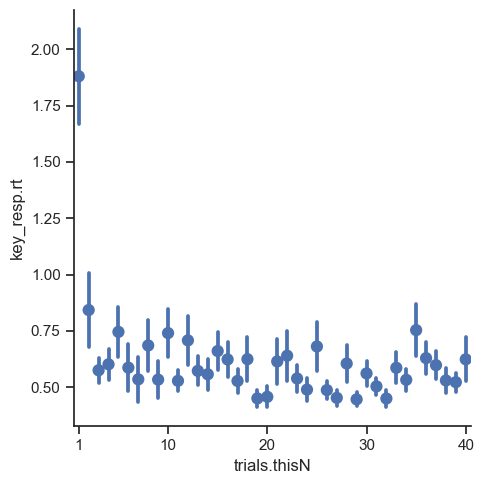

In [43]:
sns.catplot(data = dataset, x = 'trials.thisN', y = 'key_resp.rt',
            errorbar = 'se', join = False, kind = 'point')
plt.xticks(ticks = [0,9,19,29,39], labels = [1,10,20,30,40])
sns.despine()

C:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


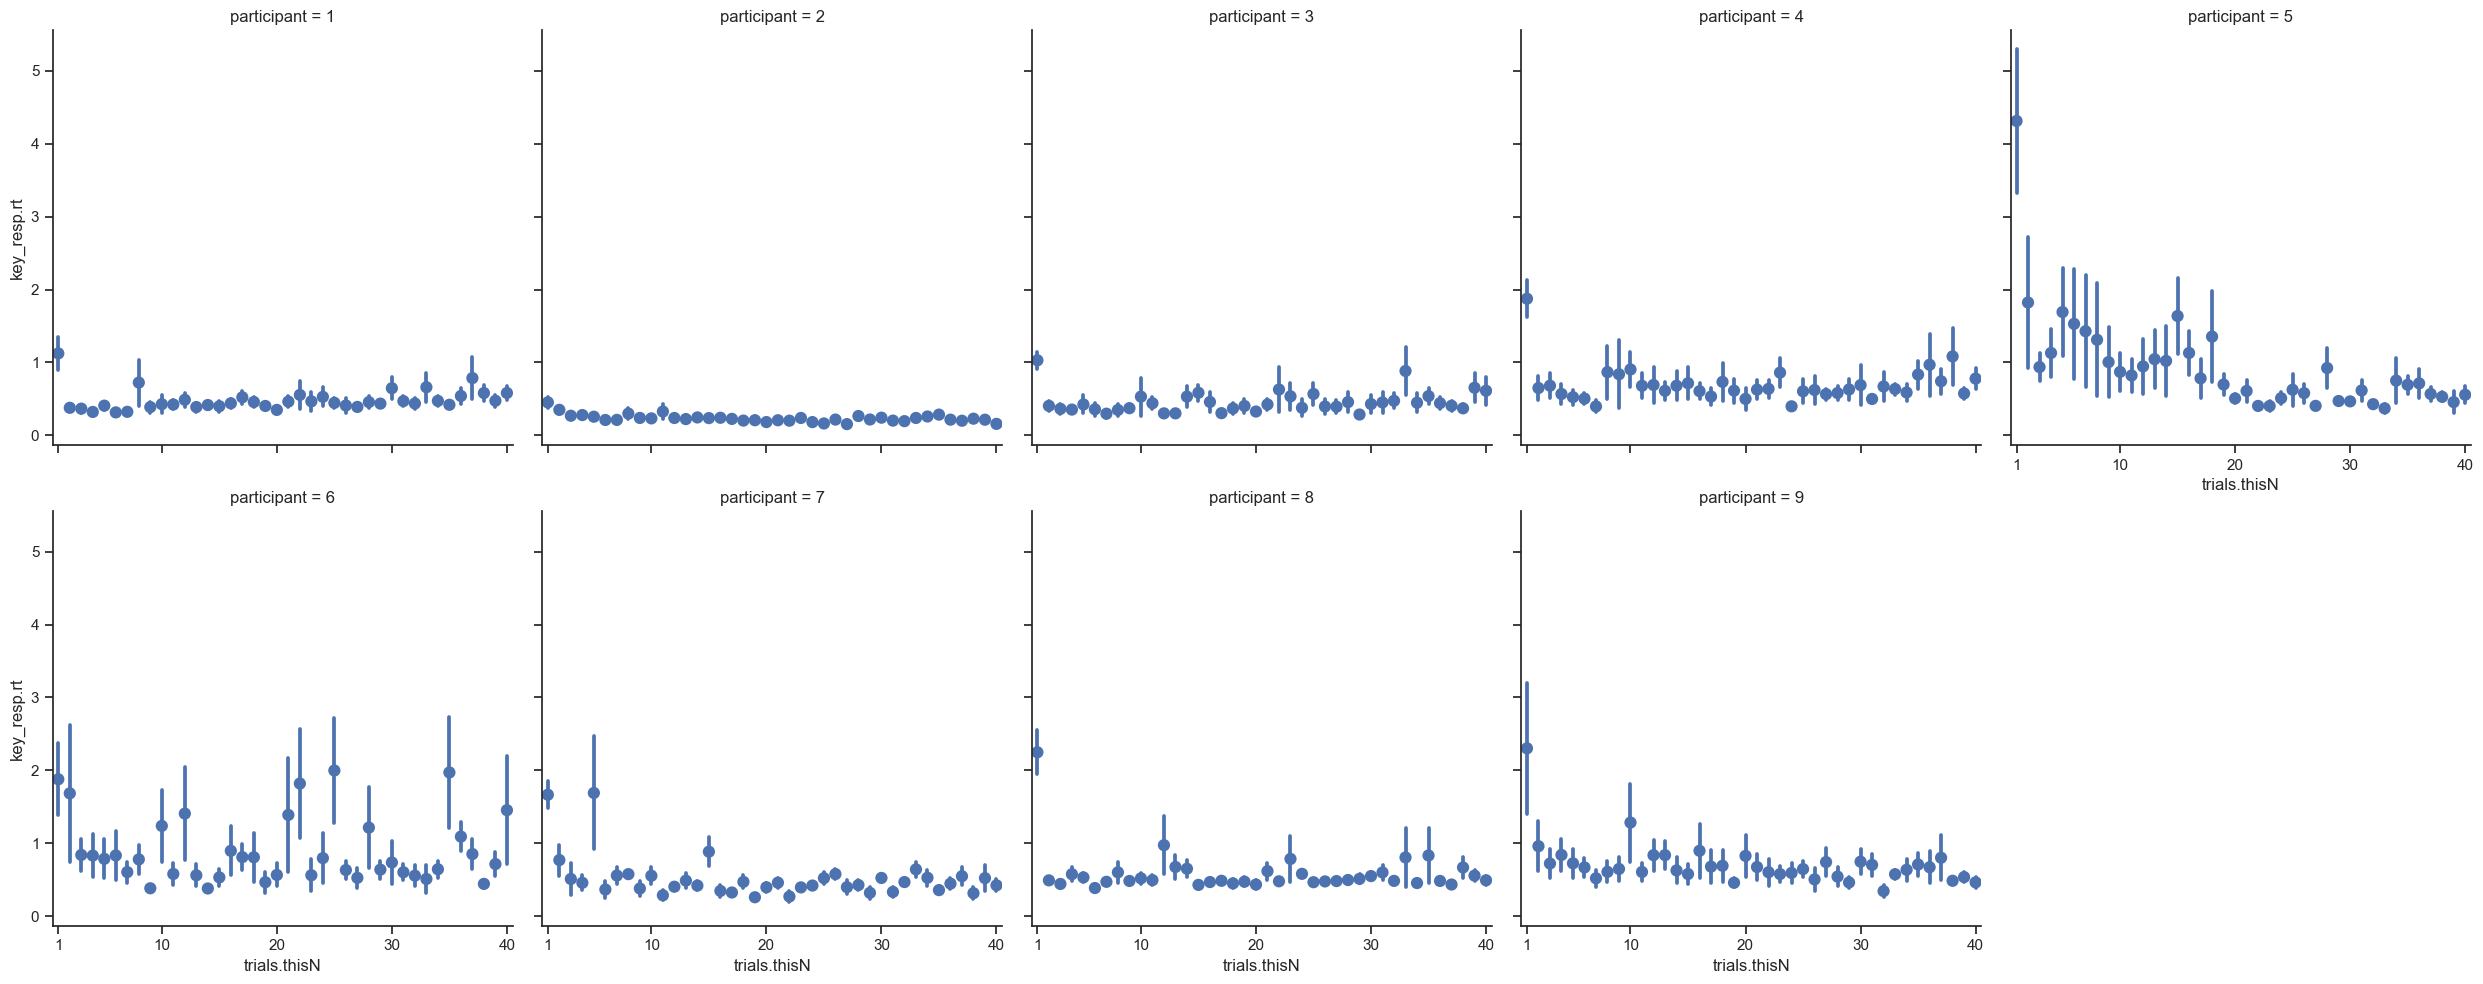

In [47]:
sns.catplot(data = dataset, x = 'trials.thisN', y = 'key_resp.rt',
            errorbar = 'se', join = False, kind = 'point', col = 'participant', col_wrap = 5)
plt.xticks(ticks = [0,9,19,29,39], labels = [1,10,20,30,40])
sns.despine()

# Transition Matrices

In [17]:
# switch-only transition matrix
%matplotlib qt
plt.figure()
pn = 1
mat = 0
for p, group in dataset[dataset['shift_t0']==1].groupby('participant'):
    ax = plt.subplot(3,3,pn)
    sns.heatmap(pd.crosstab(group['key_resp.keys'],
                                group['choice_t1'],
                                normalize = 'index',
                                dropna = False),
                    ax = ax, cmap = 'YlGnBu',
                    annot = False, fmt = '.1f', square = True,
                    xticklabels = np.arange(1,9), yticklabels = np.arange(1,9), mask=np.eye(8))
    ax.patch.set_facecolor('xkcd:white')
    mat += pd.crosstab(group['key_resp.keys'],
                                group['choice_t1'],
                                normalize = 'index',
                                dropna = False)
    ax.set_title(f'Participant {p}')
    pn+=1

In [18]:
ax = plt.subplot(111)
sns.heatmap(mat/9,
                ax = ax, cmap = 'YlGnBu',
                annot = False, fmt = '.1f', square = True,
                xticklabels = list('asdfhjkl'), yticklabels = list('asdfhjkl'), mask=np.eye(8), vmin = 0, vmax = 0.7)
ax.patch.set_facecolor('xkcd:white')
ax.tick_params(axis=u'both', which=u'both',length=0)

C:\Users\dlab\AppData\Local\Temp\ipykernel_13344\2412422652.py:1: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(111)


In [243]:
from matplotlib.colors import LinearSegmentedColormap
cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

In [338]:
fish = dataset[(dataset['shift_t0']==1)&(dataset['participant']==8)&(dataset.task == 'unstr')]
plt.figure()
ax = plt.subplot(111)
# current_cmap = plt.colormaps.get_cmap('Greens').copy()
cmap=sns.color_palette("blend:#e3d7f4,#aa87de,#8d5fd3,#7137c8", as_cmap=True)
cmap=sns.color_palette("blend:#ffcc00,#ffffd9,#c7e9b4,#7fcdbb,#41b6c4,#1d91c0,#225ea8,#253494,#081d58", as_cmap=True)
cmap = 'YlGnBu'
# current_cmap.set_extremes(under='xkcd:light grey')
sns.heatmap(pd.crosstab(fish['key_resp.keys'],
                            fish['choice_t1'],
                            normalize = 'index',
                            dropna = False),
                ax = ax, cmap = cmap,
                annot = False, fmt = '.1f', vmin = 0, vmax =0.7, square = True,
                xticklabels = list('asdfhjkl'), yticklabels = list('asdfhjkl'), mask = np.eye(8))
ax.patch.set_facecolor('xkcd:white')
# mat += pd.crosstab(group['key_resp.keys'],
#                             group['choice_t1'],
#                             normalize = 'index',
#                             dropna = False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_title(f'Participant {8}')
ax.set_xlabel('Choice at t+1')
ax.set_ylabel('Choice at t')

Text(74.45000000000006, 0.5, 'Choice at t')

In [84]:
b = []
for i in range(200):
    for j in [1,2,3,4,5,6,7,8]:
        b.append(j)
plt.figure()
c = pd.Series(b).shift(-1)
ax = plt.subplot(111)
cmap=sns.color_palette("blend:#fff6d5,#ffe680,#ffdd55,#ffcc00", as_cmap=True)
cmap=sns.color_palette("blend:#e3d7f4,#aa87de,#8d5fd3,#7137c8", as_cmap=True)
cmap=sns.color_palette("blend:#ffcc00,#ffffd9,#c7e9b4,#7fcdbb,#41b6c4,#1d91c0,#225ea8,#253494,#081d58", as_cmap=True)

mat = pd.crosstab(b,c, normalize = 'index', dropna = False).to_numpy()
mat[7,0]= 0
sns.heatmap(mat, ax = ax, cmap = 'YlGnBu',
                annot = False, fmt = '.1f',square = True, cbar = True, vmax=0.7,
                xticklabels = list('asdfhjkl'), yticklabels = list('asdfhjkl'), mask = np.eye(8))

ax.patch.set_facecolor('xkcd:white')
# mat += pd.crosstab(group['key_resp.keys'],
#                             group['choice_t1'],
#                             normalize = 'index',
#                             dropna = False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.set_title(f'Participant {8}')
ax.set_xlabel('Choice at t+1')
ax.set_ylabel('Choice at t')
plt.figure()
b = []
for i in range(100000):
    b.append(np.random.choice([1,2,3,4,5,6,7,8]))

c = pd.Series(b).shift(-1)
ax = plt.subplot(111)
cmap=sns.color_palette("blend:#e3d7f4,#aa87de,#8d5fd3,#7137c8", as_cmap=True)
mat = pd.crosstab(b,c, normalize = 'index', dropna = False)

sns.heatmap(mat, ax = ax, cmap = 'YlGnBu', vmin = 0, vmax = 0.7,
                annot = False, fmt = '.1f',square = True,cbar = False,
                xticklabels = list('asdfhjkl'), yticklabels = list('asdfhjkl'), mask = np.eye(8))
ax.patch.set_facecolor('xkcd:white')
# mat += pd.crosstab(group['key_resp.keys'],
#                             group['choice_t1'],
#                             normalize = 'index',
#                             dropna = False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.set_title(f'Participant {8}')
ax.set_xlabel('Choice at t+1')
ax.set_ylabel('Choice at t')


Text(110.44999999999997, 0.5, 'Choice at t')

In [19]:
# get tm - reward, unrewarded, diff for all 
def transition_matrixv3(sessdf, col1='key_resp.keys', col2 = 'choice_t1', shifter=-1, normalize = 'index'):
    pd.options.mode.chained_assignment = None
    sessdf.loc[:, col2] = sessdf.groupby(['participant', 'session'])[col1].shift(shifter).astype('category')
    sessdf = sessdf.dropna()
    tm = pd.crosstab(sessdf[col1], sessdf[col2], normalize = normalize, dropna = False)
    pd.options.mode.chained_assignment = 'warn'
    return tm
ind = 1
mat_rew, mat_unrew, mat_diff = 0,0,0
fig = plt.figure(figsize = (12,3.5))
for p, group in dataset.groupby('participant'):
    mask_common1 = (dataset.status==1)
    mask_common0 = (dataset.status==0)
    
    ax = plt.subplot(9,3, ind)
    # rewarded trials
    sns.heatmap(transition_matrixv3(group.loc[mask_common1]), ax = ax, cmap = 'Reds',
                annot = False, fmt = '.2f', square = True, xticklabels = list('asdfhjkl'), yticklabels = list('asdfhjkl'))
    mat_rew += transition_matrixv3(group.loc[mask_common1])
    ax.set_title(f'{p} - rewarded')
    ax.tick_params(axis=u'both', which=u'both',length=0)

    ind+=1
    
    ax = plt.subplot(9, 3, ind)
    # unrewarded trials
    sns.heatmap(transition_matrixv3(group.loc[mask_common0]), ax = ax, cmap = 'Blues',
                annot = False, fmt = '.2f', square = True, xticklabels = list('asdfhjkl'), yticklabels = list('asdfhjkl'))
    mat_unrew += transition_matrixv3(group.loc[mask_common0])
    ind+=1
    ax.set_title(f'{p} - unrewarded')
    ax.tick_params(axis=u'both', which=u'both',length=0)

    
    ax = plt.subplot(9, 3, ind)
    # diff
    sns.heatmap(transition_matrixv3(group.loc[mask_common1])-transition_matrixv3(group.loc[mask_common0]),
                ax = ax, cmap = 'coolwarm', center = 0,
                annot = False, fmt = '.2f', square = True, xticklabels = list('asdfhjkl'), yticklabels = list('asdfhjkl'))
    mat_diff += transition_matrixv3(group.loc[mask_common1])-transition_matrixv3(group.loc[mask_common0])
    ind+=1
    ax.set_title(f'{p} - diff')
    ax.tick_params(axis=u'both', which=u'both',length=0)

plt.tight_layout()
# plt.savefig('C:/Users/dlab/rishika_sim/plots/20231210/tm_all', dpi = 1000)

C:\Users\dlab\AppData\Local\Temp\ipykernel_13344\3689318675.py:46: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


In [31]:
plt.figure(figsize = (12,3.5))
ax = plt.subplot(131)
sns.heatmap(mat_rew/9, ax = ax, cmap = 'Reds',annot = False, fmt = '.2f', square = True,
            xticklabels = list('asdfhjkl'),
            yticklabels = list('asdfhjkl'), vmin = 0)
ax.set_title('Rewarded')
ax.set_xlabel('Choice at t+1')
ax.set_ylabel('Choice at t')
ax.tick_params(axis=u'both', which=u'both',length=0)
ax = plt.subplot(132)
sns.heatmap(mat_unrew/9, ax = ax, cmap = 'Blues',annot = False, fmt = '.2f', xticklabels = list('asdfhjkl'), square = True,
            yticklabels = list('asdfhjkl'), vmin = 0)
ax.set_title('Unrewarded')
ax.set_xlabel('Choice at t+1')
ax.set_ylabel('Choice at t')
ax.tick_params(axis=u'both', which=u'both',length=0)
ax = plt.subplot(133)
cmap = sns.diverging_palette(h_neg = 250, h_pos = 14, as_cmap = True, l=50, sep = 1, s = 100)
sns.heatmap(mat_diff/9, ax = ax, cmap = cmap, annot = False, fmt = '.2f', xticklabels = list('asdfhjkl'), square = True,
            yticklabels = list('asdfhjkl'), center = 0, vmax = 0.5, vmin = -0.5)
ax.set_title('Difference')
ax.set_xlabel('Choice at t+1')
ax.set_ylabel('Choice at t')
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.suptitle('Transition Matrices')
plt.tight_layout() 

# Entropy

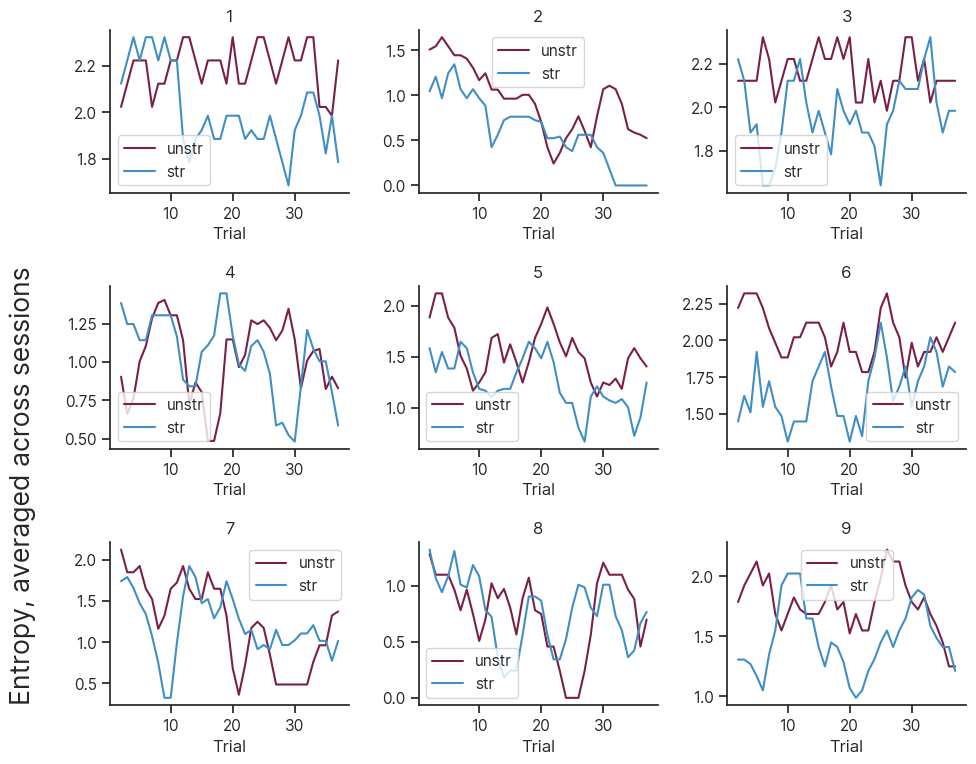

In [20]:
#################################### moving entropy ######################################
# set_cwd('/home/rishika/sim/')
# %matplotlib qt
from scipy.stats import entropy
# trialsinsess = 150
fig = plt.figure(figsize=(10,10))

entropy_mean_dict = {}
# rem_les = sessdf[~(sessdf.task.isin(['dms', 'dls', 'sham']))]

colors ={'str':'#408ec6', 'unstr':'#7a2048', 'dls':'xkcd:gold', 'dms':'xkcd:red', 'sham':'b', 'ds':'xkcd:orange'} 
for i in ['unstr', 'str']:

    for ind, (p, group) in enumerate(dataset.groupby('participant')):
        ax = plt.subplot(4, 3, ind+1)
        
        # filter by sessions>= length
        filtered = (group[group.task.isin([i])].groupby('session').head(40))
        
        # convert to numpy array
        g = filtered.groupby('session').cumcount()
        L = np.array(filtered.set_index(['session',g])
               .unstack(fill_value=0)
               .stack().groupby(level=0)
               .apply(lambda x: x.entropy.values.tolist())
               .tolist())
        
        # mean
        entropy_mean = np.mean(L, axis=0)
        entropy_mean_dict[p, i] = entropy_mean
        ax.plot(entropy_mean, label = i, c = colors[i])
        ax.set_title(p)
        ax.legend()
        ax.set_xlabel('Trial')

sns.despine()
fig.supylabel('Entropy, averaged across sessions')
plt.tight_layout()

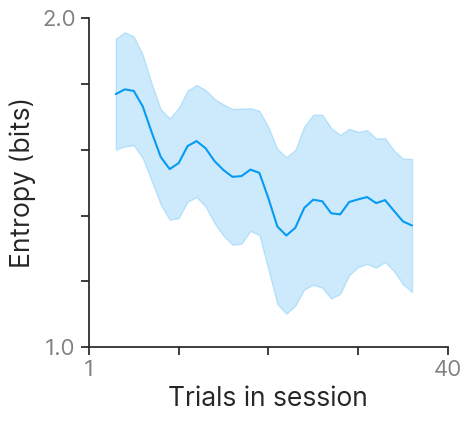

In [31]:
fig = plt.figure(figsize = (5, 4.5))
ax = plt.subplot(111)
temp_unstr = []
for (animal, env) in entropy_mean_dict.keys():
    if (env == 'unstr'):
        temp_unstr.append(entropy_mean_dict[(animal, env)])
for i, row in enumerate(temp_unstr):
    temp_unstr[i] = np.convolve(row, np.ones(3)/3, 'same')
        
mean_unstr = np.mean(np.array(temp_unstr), axis=0)
ax.plot(mean_unstr, 'xkcd:azure')
ax.fill_between(np.arange(40),mean_unstr+sem(temp_unstr, nan_policy = 'omit'),
                 mean_unstr-sem(temp_unstr, nan_policy = 'omit'), color = 'xkcd:azure', alpha = 0.2)
ax.set_xlim(0,40)
ax.set_xticks(np.arange(0,41,10), ['1', '', '', '', 40], fontsize = 'medium', color = 'grey')
ax.set_ylim(1.1, 1.8)
ax.set_yticks(np.arange(10, 21,2)/10, ['1.0', '', '', '', '', '2.0'], fontsize = 'medium', color = 'grey')
# ax.axhline(2.32, color='k', linestyle='--')
sns.despine(trim = True)
ax.set_ylabel('Entropy (bits)', fontsize = 'large')
ax.set_xlabel('Trials in session', fontsize = 'large')
plt.tight_layout()
plt.savefig('C:/Users/dlab/OneDrive - Indian Institute of Science/Drawings/awp1/ppthumanentropy.png', dpi = 300)

In [25]:
mean_unstr.shape

(40,)

In [218]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(5, 4.5), sharex = True, height_ratios=[1, 5])
# ax2 = ax1.twinx()
offset = 2
temp_unstr = []

for (animal, env) in entropy_mean_dict.keys():
    if (env == 'unstr')|(env =='str'):
        temp_unstr.append(entropy_mean_dict[(animal, env)])

for i, row in enumerate(temp_unstr):
    temp_unstr[i] = np.convolve(row, np.ones(3)/3, 'same')
        
mean_unstr = np.mean(np.array(temp_unstr), axis=0)

# Plot on the first y-axis
ax1.plot(np.arange(40),mean_unstr, 'xkcd:sky blue', label='Unstructured')
ax2.plot(np.arange(40),mean_unstr, 'xkcd:sky blue', label='Unstructured')

ax1.axhline(2.32, color='k', linestyle='--')  # max entropy possible
ax2.axhline(2.32, color='k', linestyle='--')  # max entropy possible
ax2.fill_between(np.arange(40),mean_unstr+sem(temp_unstr, nan_policy = 'omit'),
                 mean_unstr-sem(temp_unstr, nan_policy = 'omit'), color = 'xkcd:sky blue', alpha = 0.2)
# Create a broken y-axis effect
ax1.set_ylim(2.,2.35)
ax2.set_ylim(1.1, 1.7)
ax1.spines.bottom.set_visible(False)
ax1.spines.top.set_visible(False)
ax2.spines.top.set_visible(False)
# ax2.spines.bottom.set_visible(False)

# ax1.xaxis.tick_top()
# ax1.set_xticks([])
ax1.tick_params(labeltop=False)
ax2.tick_params(labeltop=False)# don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax1.xaxis.set_visible(False)

# Adding a kink on the y-axis between 0.9 and 1.8
# ax1.axvline(x=75, color='k', linestyle='--', ymin=0.2, ymax=0.8)

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# ax1.set_title('Variation in choice taken')
# ax2.set_xlabel('Trials in session')
ax2.set_xlim(0,40)
ax2.set_xticks(np.arange(0,41,10))
# fig.supylabel('Choice entropy (bits)')
# sns.despine(trim = True)
plt.tight_layout()
# plt.savefig('C:/Users/dlab/OneDrive - Indian Institute of Science/Drawings/plots/15012024/entropy_n_11.svg', dpi = 600)

In [130]:
sem(temp_unstr, nan_policy = 'omit')

array([       nan, 0.11048732, 0.1368824 , 0.12974864, 0.13943013,
       0.11825649, 0.10713639, 0.11518219, 0.110598  , 0.12853416,
       0.14612554, 0.12228574, 0.12868324, 0.10710648, 0.13669331,
       0.15168791, 0.15300452, 0.17734566, 0.14849777, 0.13254946,
       0.18610323, 0.19157937, 0.18677652, 0.20308721, 0.19461025,
       0.17571847, 0.20933279, 0.20696112, 0.18122462, 0.18189273,
       0.1270453 , 0.14247932, 0.15066206, 0.14567834, 0.14980548,
       0.17124949, 0.16804445, 0.14637102, 0.16409102,        nan])

In [186]:
entropy(calc_prob([1,2,3,4,5]), base = 2)

2.3219280948873626

In [20]:
sns.heatmap(mat/9, cmap = 'BuPu', annot = True, fmt = '.2f')

<Axes: xlabel='choice_t1', ylabel='key_resp.keys'>

In [112]:
# displacement on every switch trial (compared to chance)
dataset['disp'] = dataset['choice_t1'].astype(float) - dataset['key_resp.keys'].astype(float)
# generate random ports to go to 
rand_port = []
for k in dataset[dataset.shift_t0==1]['key_resp.keys'].values:
    ports = [1,2,3,4,5,6,7,8]
    ports.pop(int(k-1))
    rand_port.append(np.random.choice(ports))

# calculate displacement from original
randdisp = dataset[dataset.shift_t0==1]['key_resp.keys'].astype(int) - rand_port

ax = plt.subplot(111)
# plot
ax.bar(dataset[dataset.shift_t0==1].disp.value_counts(normalize = True).index, 
        dataset[dataset.shift_t0==1].disp.value_counts(normalize = True).values, 
        yerr = (dataset[dataset.shift_t0==1].groupby('participant', as_index = False)
                  .disp
                  .value_counts(normalize = True)
                  .groupby('disp')
                  .proportion
                  .sem()), color = 'xkcd:pale orange', label = 'Data', width = 1)
ax.plot(pd.Series(randdisp).value_counts(normalize = True).index,
         pd.Series(randdisp).value_counts(normalize = True).values,
         '_k', markersize = 20, label = 'Chance')
sns.despine()
# ax.set_title(title[i])
ax.set_xlabel('Displacement')
ax.set_ylim(0, 0.30)
# fig.supylabel('Probability')
plt.legend()
plt.tight_layout()

In [112]:
sns.histplot(dataset['key_resp.keys'], discrete = True)

<Axes: xlabel='key_resp.keys', ylabel='Count'>

In [68]:
dataset['disp_t1'] = dataset['choice_t2'].astype(float) - dataset['key_resp.keys'].astype(int)
g = sns.displot(data = dataset[dataset.shift_t0==1], x = 'disp_t1', col = 'disp', row = 'status',#col_wrap = 3,
            discrete = True, stat = 'probability', hue = 'status', palette = ['xkcd:pastel blue','xkcd:pale orange' ])

# plotting mean and median on the same plot
def specs(x, **kwargs):
    plt.axvline(x.mean(), c='k', ls='-', lw=1)
    plt.axvline(x.median(), c='k', ls='--', lw=1)
    plt.title('')
#     print(x.mean(), x.median(), x)
g.map(specs,'disp_t1')
plt.tight_layout()

C:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\dlab\AppData\Local\Temp\ipykernel_15568\2524652182.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


In [92]:
# normalized by status, disp category
prop = dataset[dataset.shift_t0 == 1][cols].groupby(['status', 'disp'], as_index = False).disp_t1.value_counts(normalize = True)
prop['counts'] = (dataset[dataset.shift_t0 == 1][cols].groupby(['status', 'disp'], as_index = False)
                  .disp_t1.value_counts(normalize = False)['count'])
fig = plt.figure(figsize = (20, 5))
colors = {0:'xkcd:pastel blue', 1:'xkcd:pale orange'}
pn = 1
temp = []
for (status, disp), df in prop.groupby(['status', 'disp']):    
    ax = plt.subplot(2, 14, pn)
    ax.bar(df.disp_t1, df.proportion, color = colors[status], width = 1)
    ax.axvline((df.counts*df.disp_t1).sum()/df.counts.sum(), linestyle = '-', color = 'k')
#     temp.append((df.counts*df.disp_t1).sum()/df.counts.sum())
    pn += 1
    ax.set_xlim(-7.75, +7.75)
    ax.set_title(disp)
#     ax.set_ylim(0, 0.5)
    sns.despine()
plt.tight_layout()

In [121]:
sns.displot(dataset, x = 'disp', hue = 'status', discrete = True, stat = 'probability', common_norm = False)

C:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [122]:
# normalized by status category
dataset['reward_t1'] = dataset.groupby(['participant','session']).status.shift(-1)
cols = ['reward_t1', 'disp', 'disp_t1']
prop = (dataset[dataset.shift_t0==1][cols].groupby(['reward_t1', 'disp'], as_index = False).disp_t1.mean())
prop['sem'] = (dataset[dataset.shift_t0==1][cols].groupby(['reward_t1', 'disp'], as_index = False).disp_t1.sem())['disp_t1']
g = sns.relplot(prop, x = 'disp', y = 'disp_t1', hue = 'reward_t1', kind = 'line', errorbar = 'se', marker = 'o')
ax = g.axes[0,0]
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
xmin, xmax, ymin, ymax = -7.75, 7.75, -7.75, 7.75
ax.set(xlim=(xmin-1, xmax+1), ylim=(ymin-1, ymax+1), aspect='equal')
ax.set_xlabel('Displacement at t', size=12, x=0.75)
ax.set_ylabel('Displacement at t+1', size=12, y=0.75, rotation=90)
ticks_frequency = 1
x_ticks = np.arange(-7, 7+1, ticks_frequency)
y_ticks = np.arange(-7, 7+1, ticks_frequency)
ax.set_xticks(x_ticks[x_ticks != 0])
ax.set_yticks(y_ticks[y_ticks != 0])
plt.tight_layout()

C:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\dlab\AppData\Local\Temp\ipykernel_15568\992957855.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


# regression analysis - 02-10-2023

In [ ]:
# generate regression datasets
reg_df = {}
hist = 5
dtypes = {'shift_t0':int,
         'shift_t1':int,
         'reward_t1':int,
         'reward_t2':int}

for key, dataset in full_dict.items():
    dataset['choice_t0'] = dataset['key_resp.keys']
    dataset['choice_t0'] = dataset['choice_t0'].replace({'a':1, 's':2, 'd':3, 'f':4, 'h':5, 'j':6, 'k':7, 'l':8})
    for i in range(1,hist): 
        dataset['choice_t'+str(i)] = dataset.groupby('session')['key_resp.keys'].shift(i)
        dataset['choice_t'+str(i)] = dataset['choice_t'+str(i)].replace({'a':1, 's':2, 'd':3, 'f':4, 'h':5, 'j':6, 'k':7, 'l':8})
        dataset['shift_t'+str(i-1)] = dataset['choice_t'+str(i)]==dataset['choice_t'+str(i-1)]
        dataset['shift_t'+str(i-1)] = dataset['shift_t'+str(i-1)].replace({True: 0, False: 1})
        dataset['reward_t'+str(i)] = dataset.groupby('session').status.shift(i)
        dataset['reward_t'+str(i)] = dataset['reward_t'+str(i)].replace({0:-1})
    dataset = dataset.dropna()
    dataset = dataset.astype(dtypes)
    reg_df[key] = dataset

In [ ]:
# run regressions
from opconNosepokeFunctions import *
# from regressionFunctions import *
set_cwd('/home/rishika/sim/')

human_mnlogitdf = pd.DataFrame()
pd.options.mode.chained_assignment = None

for key, dataset in reg_df.items():
    
#     halfswitch = dataset.groupby('shift_t0').sample(n = dataset.shift_t0.value_counts().min()).sort_values(by = 'trials.thisN')
    switchonly = dataset[dataset.shift_t0==1]
    
    scores_full = np.array([mnlogit_runner(dataset, hist, i) for i in ['c', 'r', 'int', 'cr']])
#     scores_halfswitch = np.array([mnlogit_runner(halfswitch, hist, i) for i in ['c', 'r', 'int', 'cr']])
    scores_switchonly = np.array([mnlogit_runner(switchonly, hist, i) for i in ['c', 'r', 'int', 'cr']])
    
    model_name = ['Choice', 'Reward', 'Interactions', 'Full']

    # scores plot
    all_scores = (scores_full, scores_halfswitch, scores_switchonly)
    train_dataset = ['full', 'halfswitch', 'switchonly']
    for ind, scores in enumerate(all_scores):
        fig, ax = plt.subplots(scores.shape[0], scores.shape[1], figsize = (10,10))
        
        title = ['AIC', 'BIC', 'Pseudo R squared']
        color = ['b', 'r', 'g']
        # returns score plot 
        for i in range(scores.shape[0]):
            for j in range(scores.shape[1]):
                ax[i, j].plot(np.arange(1, len(scores[i, j])+1), scores[i,j], c = color[j])
                ax[i, j].set_title(title[j])
                ax[i, j].set_xlabel('Trial history')
                ax[i, j].set_xlim(1,len(scores[i,j])+1)
        #             best_model = 1+np.where(scores[i,j]==min(scores[i,j]))[0][0]
        #         ax[i, j].axvline(best_model, color='r')
            ax2 = ax[i,j].twinx()
            ax2.set_ylabel(f'{model_name[i]} model')
            ax2.set_yticks([])

        sns.despine()
        plt.suptitle('Model Scores')
        plt.tight_layout()
        plt.savefig(f'plots/human_task/train_{train_dataset[ind]}_model_scores_{key}.png', dpi = 300)

    # get the best trial history from bic scores
    best_ln = [score_plot(i) for i in scores_full]
    best_ln_switchonly = [score_plot(i) for i in scores_switchonly]
#     best_ln_halfswitch = [score_plot(i) for i in scores_halfswitch]
    
    # store best trial history separately for each model
    best_len_c, best_len_r, best_len_int, best_len_cr = best_ln
    best_len_c_switchonly, best_len_r_switchonly, best_len_int_switchonly, best_len_cr_switchonly = best_ln_switchonly
#     best_len_c_halfswitch, best_len_r_halfswitch, best_len_int_halfswitch, best_len_cr_halfswitch = best_ln_halfswitch
    
    # regenerate best model
    best_models = [gen_model(dataset, best_ln[i], f) for i, f in enumerate(['c', 'r', 'int', 'cr'])]
    best_models_switchonly = [gen_model(switchonly, best_ln_switchonly[i], f) for i, f in enumerate(['c', 'r', 'int', 'cr'])]
#     best_models_halfswitch = [gen_model(halfswitch, best_ln_halfswitch[i], f) for i, f in enumerate(['c', 'r', 'int', 'cr'])]
    
    # unpack best models by category
    best_model_c, best_model_r, best_model_int, best_model_cr = best_models
#     best_model_c_halfswitch, best_model_r_halfswitch, best_model_int_halfswitch, best_model_cr_halfswitch = best_models_halfswitch
    best_model_c_switchonly, best_model_r_switchonly, best_model_int_switchonly, best_model_cr_switchonly = best_models_switchonly

    # evaluate model on full dataset - model_eval(model, testing dataset)
    # training full, prediction full and plot full and switchonly
    cm_c, accuracy_c, full_cm_c, shift_cm_c = model_eval(best_model_c[0], dataset, return_shiftcm = True, arms = 8)
    cm_r, accuracy_r, full_cm_r, shift_cm_r = model_eval(best_model_r[0], dataset, return_shiftcm = True, arms = 8)
    cm_int, accuracy_int, full_cm_int, shift_cm_int = model_eval(best_model_int[0], dataset, return_shiftcm=True, arms = 8)
    cm_cr, accuracy_cr, full_cm_cr, shift_cm_cr = model_eval(best_model_cr[0], dataset, return_shiftcm = True, arms = 8)
    baccuracy_c = np.diag(full_cm_c).mean()
    baccuracy_r = np.diag(full_cm_r).mean()
    baccuracy_int = np.diag(full_cm_int).mean()
    baccuracy_cr = np.diag(full_cm_cr).mean()
    
    # training full, prediction switchonly
    _, accuracy_c_test_switchonly, full_cm_c_test_switchonly = model_eval(best_model_c[0], switchonly, arms = 8)
    _, accuracy_r_test_switchonly, full_cm_r_test_switchonly = model_eval(best_model_r[0], switchonly, arms = 8)
    _, accuracy_int_test_switchonly, full_cm_int_test_switchonly = model_eval(best_model_int[0], switchonly, arms = 8)
    _, accuracy_cr_test_switchonly, full_cm_cr_test_switchonly = model_eval(best_model_cr[0], switchonly, arms = 8)
    baccuracy_c_test_switchonly = np.diag(full_cm_c_test_switchonly).mean()
    baccuracy_r_test_switchonly = np.diag(full_cm_r_test_switchonly).mean()
    baccuracy_int_test_switchonly = np.diag(full_cm_int_test_switchonly).mean()
    baccuracy_cr_test_switchonly = np.diag(full_cm_cr_test_switchonly).mean()
    
#     # training halfswitch, prediction full and plot full and switchonly
#     _, accuracy_c_halfswitch, full_cm_c_halfswitch, shift_cm_c_halfswitch = model_eval(best_model_c_halfswitch[0], halfswitch, return_shiftcm = True, arms = 8)
#     _, accuracy_r_halfswitch, full_cm_r_halfswitch, shift_cm_r_halfswitch = model_eval(best_model_r_halfswitch[0], halfswitch, return_shiftcm = True, arms = 8)
#     _, accuracy_int_halfswitch, full_cm_int_halfswitch, shift_cm_int_halfswitch = model_eval(best_model_int_halfswitch[0], halfswitch, return_shiftcm=True, arms = 8)
#     _, accuracy_cr_halfswitch, full_cm_cr_halfswitch, shift_cm_cr_halfswitch = model_eval(best_model_cr_halfswitch[0], halfswitch, return_shiftcm = True, arms = 8)
#     baccuracy_c_halfswitch = np.diag(full_cm_c_halfswitch).mean()
#     baccuracy_r_halfswitch = np.diag(full_cm_r_halfswitch).mean()
#     baccuracy_int_halfswitch = np.diag(full_cm_int_halfswitch).mean()
#     baccuracy_cr_halfswitch = np.diag(full_cm_cr_halfswitch).mean()
    
#     # training halfswitch, prediction switchonly
#     _, accuracy_c_halfswitch_test_switchonly, full_cm_c_halfswitch_test_switchonly = model_eval(best_model_c_halfswitch[0], switchonly, arms = 8)
#     _, accuracy_r_halfswitch_test_switchonly, full_cm_r_halfswitch_test_switchonly = model_eval(best_model_r_halfswitch[0], switchonly, arms = 8)
#     _, accuracy_int_halfswitch_test_switchonly, full_cm_int_halfswitch_test_switchonly = model_eval(best_model_int_halfswitch[0], switchonly, arms = 8)
#     _, accuracy_cr_halfswitch_test_switchonly, full_cm_cr_halfswitch_test_switchonly = model_eval(best_model_cr_halfswitch[0], switchonly, arms = 8)
#     baccuracy_c_halfswitch_test_switchonly = np.diag(full_cm_c_halfswitch_test_switchonly).mean()
#     baccuracy_r_halfswitch_test_switchonly = np.diag(full_cm_r_halfswitch_test_switchonly).mean()
#     baccuracy_int_halfswitch_test_switchonly = np.diag(full_cm_int_halfswitch_test_switchonly).mean()
#     baccuracy_cr_halfswitch_test_switchonly = np.diag(full_cm_cr_halfswitch_test_switchonly).mean()
    
    # training switchonly, prediction full
    _, accuracy_c_switchonly, full_cm_c_switchonly = model_eval(best_model_c_switchonly[0], switchonly, arms = 8)
    _, accuracy_r_switchonly, full_cm_r_switchonly = model_eval(best_model_r_switchonly[0], switchonly, arms = 8)
    _, accuracy_int_switchonly, full_cm_int_switchonly = model_eval(best_model_int_switchonly[0], switchonly, arms = 8)
    _, accuracy_cr_switchonly, full_cm_cr_switchonly = model_eval(best_model_cr_switchonly[0], switchonly, arms = 8)
    baccuracy_c_switchonly = np.diag(full_cm_c_switchonly).mean()
    baccuracy_r_switchonly = np.diag(full_cm_r_switchonly).mean()
    baccuracy_int_switchonly = np.diag(full_cm_int_switchonly).mean()
    baccuracy_cr_switchonly = np.diag(full_cm_cr_switchonly).mean()
    
    # training switchonly, prediction switchonly
    _, accuracy_c_switchonly_test_switchonly, full_cm_c_switchonly_test_switchonly = model_eval(best_model_c_switchonly[0], switchonly, arms = 8)
    _, accuracy_r_switchonly_test_switchonly, full_cm_r_switchonly_test_switchonly = model_eval(best_model_r_switchonly[0], switchonly, arms = 8)
    _, accuracy_int_switchonly_test_switchonly, full_cm_int_switchonly_test_switchonly = model_eval(best_model_int_switchonly[0], switchonly, arms = 8)
    _, accuracy_cr_switchonly_test_switchonly, full_cm_cr_switchonly_test_switchonly = model_eval(best_model_cr_switchonly[0], switchonly, arms = 8)
    baccuracy_c_switchonly_test_switchonly = np.diag(full_cm_c_switchonly_test_switchonly).mean()
    baccuracy_r_switchonly_test_switchonly = np.diag(full_cm_r_switchonly_test_switchonly).mean()
    baccuracy_int_switchonly_test_switchonly = np.diag(full_cm_int_switchonly_test_switchonly).mean()
    baccuracy_cr_switchonly_test_switchonly = np.diag(full_cm_cr_switchonly_test_switchonly).mean()
    
     # draw confusion matrices for testing on full dataset
    cms = np.array([cm_c, cm_r, cm_int, cm_cr])
    title = '- Testing all choices'
    fig, ax = plt.subplots(nrows = cms.shape[0], ncols = cms.shape[1], sharex = True, sharey = True, figsize = (7,7))
    row = 0

    for cm in cms:
        for i in range(len(cm)):
            sns.heatmap(row_norm(cm[i,:,:]), annot = True, cmap = 'Greys', fmt = '.2',
                        xticklabels = ['others', f'port'], linewidth = .5,
                        yticklabels = ['others', f'port'], cbar = False, ax = ax[row,i])
            ax[row,i].set_title(f'Port {i+1}')
            ax[row,i].tick_params(left=False, bottom=False, right = False)

        ax2 = ax[row,i].twinx()
        ax2.set_ylabel(f'{model_name[row]} model')
        ax2.set_yticks([])
        ax[row,i].tick_params(left = False)
        row+=1
    fig.supxlabel('predicted')
    fig.supylabel('actual')
    plt.suptitle(f'Confusion matrices {title}')
    sns.despine(fig = fig, bottom = True, left = True)
    plt.tight_layout()
    plt.savefig(f'plots/human_task/portwise_cm_{key}_train_full_test_full.png', dpi = 300)

    # store data in a df
    ddict = [
        {'model':'choice', 'participant':key,'train_on':'full', 'best_len':best_len_c, 'test_on':'full', 'pred_accuracy':accuracy_c, 'aic':best_model_c[1][0], 'bic':best_model_c[1][1], 'prsq':best_model_c[1][2], 'llnull':best_model_c[0].llnull, 'bal_accuracy':baccuracy_c},
    {'model':'reward', 'participant':key,'train_on':'full', 'best_len':best_len_r, 'test_on':'full', 'pred_accuracy':accuracy_r,'aic':best_model_r[1][0], 'bic':best_model_r[1][1], 'prsq':best_model_r[1][2], 'llnull':best_model_r[0].llnull,'bal_accuracy':baccuracy_r},
    {'model':'interactions', 'participant':key, 'train_on':'full','best_len':best_len_int, 'test_on':'full', 'pred_accuracy':accuracy_int, 'aic':best_model_int[1][0], 'bic':best_model_int[1][1], 'prsq':best_model_int[1][2], 'llnull':best_model_int[0].llnull, 'bal_accuracy':baccuracy_int},
    {'model':'full', 'participant':key, 'train_on':'full','best_len':best_len_cr, 'test_on':'full', 'pred_accuracy':accuracy_cr, 'aic':best_model_cr[1][0], 'bic':best_model_cr[1][1], 'prsq':best_model_cr[1][2], 'llnull':best_model_cr[0].llnull,'bal_accuracy':baccuracy_cr},
    {'model':'choice', 'participant':key, 'train_on':'full','best_len':best_len_c, 'test_on':'switchonly', 'pred_accuracy':accuracy_c_test_switchonly, 'aic':best_model_c[1][0], 'bic':best_model_c[1][1], 'prsq':best_model_c[1][2], 'llnull':best_model_c[0].llnull,'bal_accuracy':baccuracy_c_test_switchonly},
    {'model':'reward', 'participant':key,'train_on':'full', 'best_len':best_len_r, 'test_on':'switchonly', 'pred_accuracy':accuracy_r_test_switchonly, 'aic':best_model_r[1][0], 'bic':best_model_r[1][1], 'prsq':best_model_r[1][2], 'llnull':best_model_r[0].llnull,'bal_accuracy':baccuracy_r_test_switchonly},
    {'model':'interactions', 'participant':key,'train_on':'full', 'best_len':best_len_int, 'test_on':'switchonly', 'pred_accuracy':accuracy_int_test_switchonly, 'aic':best_model_int[1][0], 'bic':best_model_int[1][1], 'prsq':best_model_int[1][2], 'llnull':best_model_int[0].llnull,'bal_accuracy':baccuracy_int_test_switchonly},
    {'model':'full', 'participant':key, 'train_on':'full', 'best_len':best_len_cr, 'test_on':'switchonly', 'pred_accuracy':accuracy_cr_test_switchonly, 'aic':best_model_cr[1][0], 'bic':best_model_cr[1][1], 'prsq':best_model_cr[1][2], 'llnull':best_model_cr[0].llnull,'bal_accuracy':baccuracy_cr_test_switchonly},
#     {'model':'choice', 'participant':key, 'train_on':'halfswitch','best_len':best_len_c, 'test_on':'full', 'pred_accuracy':accuracy_c_halfswitch, 'aic':best_model_c_halfswitch[1][0], 'bic':best_model_c_halfswitch[1][1], 'prsq':best_model_c_halfswitch[1][2], 'llnull':best_model_c_halfswitch[0].llnull,'bal_accuracy':baccuracy_c_halfswitch},
#     {'model':'reward', 'participant':key, 'train_on':'halfswitch','best_len':best_len_r, 'test_on':'full', 'pred_accuracy':accuracy_r_halfswitch, 'aic':best_model_r_halfswitch[1][0], 'bic':best_model_r_halfswitch[1][1], 'prsq':best_model_r_halfswitch[1][2], 'llnull':best_model_r_halfswitch[0].llnull,'bal_accuracy':baccuracy_r_halfswitch},
#     {'model':'interactions', 'participant':key, 'train_on':'halfswitch','best_len':best_len_int, 'test_on':'full', 'pred_accuracy':accuracy_int_halfswitch, 'aic':best_model_int_halfswitch[1][0], 'bic':best_model_int_halfswitch[1][1], 'prsq':best_model_int_halfswitch[1][2], 'llnull':best_model_int_halfswitch[0].llnull,'bal_accuracy':baccuracy_int_halfswitch},
#     {'model':'full', 'participant':key, 'train_on':'halfswitch','best_len':best_len_cr, 'test_on':'full', 'pred_accuracy':accuracy_cr_halfswitch, 'aic':best_model_cr_halfswitch[1][0], 'bic':best_model_cr_halfswitch[1][1], 'prsq':best_model_cr_halfswitch[1][2], 'llnull':best_model_cr_halfswitch[0].llnull, 'bal_accuracy':baccuracy_cr_halfswitch},
#     {'model':'choice', 'participant':key,'train_on':'halfswitch', 'best_len':best_len_c, 'test_on':'switchonly', 'pred_accuracy':accuracy_c_halfswitch_test_switchonly, 'aic':best_model_c_halfswitch[1][0], 'bic':best_model_c_halfswitch[1][1], 'prsq':best_model_c_halfswitch[1][2], 'llnull':best_model_c_halfswitch[0].llnull,'bal_accuracy':baccuracy_c_halfswitch_test_switchonly},
#     {'model':'reward', 'participant':key, 'train_on':'halfswitch','best_len':best_len_r, 'test_on':'switchonly', 'pred_accuracy':accuracy_r_halfswitch_test_switchonly, 'aic':best_model_r_halfswitch[1][0], 'bic':best_model_r_halfswitch[1][1], 'prsq':best_model_r_halfswitch[1][2], 'llnull':best_model_r_halfswitch[0].llnull, 'bal_accuracy':baccuracy_r_halfswitch_test_switchonly},
#     {'model':'interactions', 'participant':key,'train_on':'halfswitch', 'best_len':best_len_int, 'test_on':'switchonly', 'pred_accuracy':accuracy_int_halfswitch_test_switchonly, 'aic':best_model_int_halfswitch[1][0], 'bic':best_model_int_halfswitch[1][1], 'prsq':best_model_int_halfswitch[1][2], 'llnull':best_model_int_halfswitch[0].llnull,'bal_accuracy':baccuracy_int_halfswitch_test_switchonly},
#     {'model':'full', 'participant':key, 'train_on':'halfswitch','best_len':best_len_cr, 'test_on':'switchonly', 'pred_accuracy':accuracy_cr_halfswitch_test_switchonly, 'aic':best_model_cr_halfswitch[1][0], 'bic':best_model_cr_halfswitch[1][1], 'prsq':best_model_cr_halfswitch[1][2], 'llnull':best_model_cr_halfswitch[0].llnull,'bal_accuracy':baccuracy_cr_halfswitch_test_switchonly},
    {'model':'choice', 'participant':key, 'train_on':'switchonly', 'best_len':best_len_c, 'test_on':'full', 'pred_accuracy':accuracy_c_switchonly, 'aic':best_model_c_switchonly[1][0], 'bic':best_model_c_switchonly[1][1], 'prsq':best_model_c_switchonly[1][2], 'llnull':best_model_c_switchonly[0].llnull, 'bal_accuracy':baccuracy_c_switchonly},
    {'model':'reward', 'participant':key, 'train_on':'switchonly','best_len':best_len_r, 'test_on':'full', 'pred_accuracy':accuracy_r_switchonly, 'aic':best_model_r_switchonly[1][0], 'bic':best_model_r_switchonly[1][1], 'prsq':best_model_r_switchonly[1][2], 'llnull':best_model_r_switchonly[0].llnull, 'bal_accuracy':baccuracy_r_switchonly},
    {'model':'interactions', 'participant':key, 'train_on':'switchonly','best_len':best_len_int, 'test_on':'full', 'pred_accuracy':accuracy_int_switchonly, 'aic':best_model_int_switchonly[1][0], 'bic':best_model_int_switchonly[1][1], 'prsq':best_model_int_switchonly[1][2], 'llnull':best_model_int_switchonly[0].llnull, 'bal_accuracy':baccuracy_int_switchonly},
    {'model':'full', 'participant':key, 'train_on':'switchonly','best_len':best_len_cr, 'test_on':'full', 'pred_accuracy':accuracy_cr_switchonly, 'aic':best_model_cr_switchonly[1][0], 'bic':best_model_cr_switchonly[1][1], 'prsq':best_model_cr_switchonly[1][2], 'llnull':best_model_cr_switchonly[0].llnull, 'bal_accuracy':baccuracy_cr_switchonly},
    {'model':'choice', 'participant':key, 'train_on':'switchonly','best_len':best_len_c, 'test_on':'switchonly', 'pred_accuracy':accuracy_c_switchonly_test_switchonly, 'aic':best_model_c_switchonly[1][0], 'bic':best_model_c_switchonly[1][1], 'prsq':best_model_c_switchonly[1][2], 'llnull':best_model_c_switchonly[0].llnull, 'bal_accuracy':baccuracy_c_switchonly_test_switchonly},
    {'model':'reward', 'participant':key, 'train_on':'switchonly','best_len':best_len_r, 'test_on':'switchonly', 'pred_accuracy':accuracy_r_switchonly_test_switchonly, 'aic':best_model_r_switchonly[1][0], 'bic':best_model_r_switchonly[1][1], 'prsq':best_model_r_switchonly[1][2], 'llnull':best_model_r_switchonly[0].llnull, 'bal_accuracy':baccuracy_r_switchonly_test_switchonly},
    {'model':'interactions', 'participant':key, 'train_on':'switchonly','best_len':best_len_int, 'test_on':'switchonly', 'pred_accuracy':accuracy_int_switchonly_test_switchonly, 'aic':best_model_int_switchonly[1][0], 'bic':best_model_int_switchonly[1][1], 'prsq':best_model_int_switchonly[1][2], 'llnull':best_model_int_switchonly[0].llnull, 'bal_accuracy':baccuracy_int_switchonly_test_switchonly},
    {'model':'full', 'participant':key, 'train_on':'switchonly','best_len':best_len_cr, 'test_on':'switchonly', 'pred_accuracy':accuracy_cr_switchonly_test_switchonly, 'aic':best_model_cr_switchonly[1][0], 'bic':best_model_cr_switchonly[1][1], 'prsq':best_model_cr_switchonly[1][2], 'llnull':best_model_cr_switchonly[0].llnull, 'bal_accuracy':baccuracy_cr_switchonly_test_switchonly}]

    human_mnlogitdf = pd.concat([human_mnlogitdf,pd.DataFrame(ddict)], ignore_index = True)
    plt.close()
    print('iter done, participant', key)
pd.options.mode.chained_assignment = 'warn'

In [ ]:
def gen_model(dataset, hist = 5, formula_type = 'c'):
    
    # check which formula type and generate formula:
    if hist>=2:
        if formula_type == 'c':
            formula = 'choice_t0 ~ C(choice_t1)'
            for i in range(2,hist):
                formula+='+C(choice_t'+str(i)+')+'
                formula = formula[:-1]

        elif formula_type == 'r':
            formula = 'choice_t0 ~ C(reward_t1)'
            for i in range(2,hist):
                formula+='+C(reward_t'+str(i)+')+'
                formula = formula[:-1]

        elif formula_type == 'int':
            formula = 'choice_t0 ~ C(choice_t1):C(reward_t1)'
            for i in range(2, hist):
                formula+='+C(choice_t'+str(i)+'):C(reward_t'+str(i)+')+'
                formula = formula[:-1]

        elif formula_type == 'cr':
            formula = 'choice_t0 ~ C(choice_t1)*C(reward_t1)'
            for i in range(2,hist):
                formula+='+C(choice_t'+str(i)+')*C(reward_t'+str(i)+')+'
                formula = formula[:-1]            
    else:
        if formula_type == 'c': formula = 'choice_t0 ~ C(choice_t1)'
        elif formula_type == 'r': formula = 'choice_t0 ~ C(reward_t1)'
        elif formula_type == 'int': formula = 'choice_t0 ~ C(choice_t1):C(reward_t1)'
        elif formula_type == 'cr': formula = 'choice_t0 ~ C(choice_t1)*C(reward_t1)'
            
    # generate model of given hist
    model = smf.mnlogit(formula = formula, data = dataset).fit_regularized(method = 'l1', maxiter = 100)
    
    # pack scores 
    scores = (model.aic, model.bic, model.prsquared)
    
    return model, scores

def mnlogit_runner(dataset, hist = 5, formula_type = 'c'):
    aic_hist, bic_hist, prsquared_hist = [], [], []
    for i in range(hist):
        model, scores = gen_model(dataset, i, formula_type)
        aic, bic, prsquared = scores
        aic_hist.append(aic)
        bic_hist.append(bic)
        prsquared_hist.append(prsquared)
    scores_hist = (aic_hist, bic_hist, prsquared_hist)
    return scores_hist


In [ ]:
human_mnlogitdf.groupby(['model']).pred_accuracy.mean()

In [ ]:
human_mnlogitdf.groupby(['model']).prsq.mean()

In [ ]:
################################## simulated q learning dataset ###############################
# info
arms = 8

# reward prob generator
def fxn_str(mean, arms):
    x = np.linspace(1, arms, arms)
    sig = 1.75/2
    amp = 0.7
    vo = 0.1
    gx = (amp*np.exp(-0.5*((x-mean)**2)/(sig**2)))+vo
    return gx

def fxn_unstr(mean, arms):
    x = np.linspace(1, arms, arms)
    sig = 1.75/2
    amp = 0.7
    vo = 0.1
    gx = (amp*np.exp(-0.5*((x-mean)**2)/(sig**2)))+vo
    gx = np.random.permutation(gx)
    return gx

def rewarding(prob, reward_val):
    temp = reward_val
    rand = np.random.uniform(0, 1)
    return temp if rand <= prob else 0

# pairs of params 
alphas = [0.05, 0.1, 0.5]
taus = [0.05, 0.1, 0.5]

# num_iter
num_iters = 10
params = np.array(np.meshgrid(alphas, taus)).T.reshape(-1,2)

human_sim_qldf = pd.DataFrame(columns = ['iter','participant','task', 'alpha','tau', 'sessnum', 'rewprob', 'trial',
                                   'action', 'reward', 'qvalue'])

for paramset in params:  
    alpha, tau = paramset
    
    for (participant, task), data in dataset.groupby(['participant', 'task']):
        
        if 'unstr' in task:
            for iteri in range(num_iters):
                for sessnum, group in data.groupby('session'):
                    q = np.zeros(arms)
                    rp = fxn_unstr(np.random.choice(np.arange(1,9)), arms)

                    for ind, trial in group.iterrows():
                        # softmax prob of choosing actions
                        invtemp=1/tau
                        P = np.exp(invtemp*(q))
                        P = P/ np.sum(P)

                        # which action on this trial
                        a_ind = np.random.multinomial(1, P)
                        a = range(arms)[a_ind.nonzero()[0][0]]

                        # probability of each action on this trial
                        p = P[a]

                        # rewarded?
                        r = rewarding(rp[a], 1)

                        # compute q value
                        q[a] = q[a] + alpha*(r - q[a])

                        # store everything
                        human_sim_qldf.loc[len(human_sim_qldf)] = [iteri, participant, task, alpha, tau, sessnum, rp[a], trial, a+1, r, q[a]]
                    
        else:
            for iteri in range(num_iters):
                for sessnum, group in data.groupby('session'):
                    q = np.zeros(arms)
                    p = np.zeros(group.shape[0])
                    rp = fxn_str(np.random.choice(np.arange(1,9)), arms)

                    for ind, trial in group.iterrows():
                        # softmax prob of choosing actions
                        invtemp=1/tau
                        P = np.exp(invtemp*(q))
                        P = P/ np.sum(P)

                        # which action on this trial
                        a_ind = np.random.multinomial(1, P)
                        a = range(arms)[a_ind.nonzero()[0][0]]

                        # probability of each action on this trial
                        p = P[a]

                        # rewarded?
                        r = rewarding(rp[a], 1)

                        # compute q value
                        q[a] = q[a] + alpha*(r - q[a])

                        # store everything
                        human_sim_qldf.loc[len(human_sim_qldf)] = [iteri, participant, task, alpha, tau, sessnum, rp[a], trial, a+1, r, q[a]]
        print('iter done,', iteri, paramset, task, participant)

In [ ]:
# run regressions
from opconNosepokeFunctions import *
# from regressionFunctions import *
set_cwd('/home/rishika/sim/')

sim_human_mnlogitdf = pd.DataFrame()
pd.options.mode.chained_assignment = None
# generate regression datasets
sim_reg_df = {}
hist = 5
dtypes = {'shift_t0':int,
         'shift_t1':int,
         'reward_t1':int,
         'reward_t2':int}

for (key, alpha, tau), dataset in human_sim_qldf.groupby(['participant', 'alpha', 'tau']):
    dataset['choice_t0'] = dataset['action']
    for i in range(1,hist): 
        dataset['choice_t'+str(i)] = dataset.groupby('sessnum')['action'].shift(i)
        dataset['shift_t'+str(i-1)] = dataset['choice_t'+str(i)]==dataset['choice_t'+str(i-1)]
        dataset['shift_t'+str(i-1)] = dataset['shift_t'+str(i-1)].replace({True: 0, False: 1})
        dataset['reward_t'+str(i)] = dataset.groupby('sessnum').reward.shift(i)
        dataset['reward_t'+str(i)] = dataset['reward_t'+str(i)].replace({0:-1})
    dataset = dataset.dropna()
    dataset = dataset.astype(dtypes)
#     sim_reg_df[key] = dataset
    
#     halfswitch = dataset.groupby('shift_t0').sample(n = dataset.shift_t0.value_counts().min()).sort_values(by = 'trials.thisN')
    switchonly = dataset[dataset.shift_t0==1]
    
    scores_full = np.array([mnlogit_runner(dataset, hist, i) for i in ['c', 'r', 'int', 'cr']])
#     scores_halfswitch = np.array([mnlogit_runner(halfswitch, hist, i) for i in ['c', 'r', 'int', 'cr']])
    scores_switchonly = np.array([mnlogit_runner(switchonly, hist, i) for i in ['c', 'r', 'int', 'cr']])
    
    model_name = ['Choice', 'Reward', 'Interactions', 'Full']

    # scores plot
    all_scores = (scores_full, scores_halfswitch, scores_switchonly)
    train_dataset = ['full', 'halfswitch', 'switchonly']
    for ind, scores in enumerate(all_scores):
        fig, ax = plt.subplots(scores.shape[0], scores.shape[1], figsize = (10,10))
        
        title = ['AIC', 'BIC', 'Pseudo R squared']
        color = ['b', 'r', 'g']
        # returns score plot 
        for i in range(scores.shape[0]):
            for j in range(scores.shape[1]):
                ax[i, j].plot(np.arange(1, len(scores[i, j])+1), scores[i,j], c = color[j])
                ax[i, j].set_title(title[j])
                ax[i, j].set_xlabel('Trial history')
                ax[i, j].set_xlim(1,len(scores[i,j])+1)
        #             best_model = 1+np.where(scores[i,j]==min(scores[i,j]))[0][0]
        #         ax[i, j].axvline(best_model, color='r')
            ax2 = ax[i,j].twinx()
            ax2.set_ylabel(f'{model_name[i]} model')
            ax2.set_yticks([])

        sns.despine()
        plt.suptitle('Model Scores')
        plt.tight_layout()
        plt.savefig(f'plots/human_task/sim_train_{train_dataset[ind]}_model_scores_{key}.png', dpi = 300)

    # get the best trial history from bic scores
    best_ln = [score_plot(i) for i in scores_full]
    best_ln_switchonly = [score_plot(i) for i in scores_switchonly]
#     best_ln_halfswitch = [score_plot(i) for i in scores_halfswitch]
    
    # store best trial history separately for each model
    best_len_c, best_len_r, best_len_int, best_len_cr = best_ln
    best_len_c_switchonly, best_len_r_switchonly, best_len_int_switchonly, best_len_cr_switchonly = best_ln_switchonly
#     best_len_c_halfswitch, best_len_r_halfswitch, best_len_int_halfswitch, best_len_cr_halfswitch = best_ln_halfswitch
    
    # regenerate best model
    best_models = [gen_model(dataset, best_ln[i], f) for i, f in enumerate(['c', 'r', 'int', 'cr'])]
    best_models_switchonly = [gen_model(switchonly, best_ln_switchonly[i], f) for i, f in enumerate(['c', 'r', 'int', 'cr'])]
#     best_models_halfswitch = [gen_model(halfswitch, best_ln_halfswitch[i], f) for i, f in enumerate(['c', 'r', 'int', 'cr'])]
    
    # unpack best models by category
    best_model_c, best_model_r, best_model_int, best_model_cr = best_models
#     best_model_c_halfswitch, best_model_r_halfswitch, best_model_int_halfswitch, best_model_cr_halfswitch = best_models_halfswitch
    best_model_c_switchonly, best_model_r_switchonly, best_model_int_switchonly, best_model_cr_switchonly = best_models_switchonly

    # evaluate model on full dataset - model_eval(model, testing dataset)
    # training full, prediction full and plot full and switchonly
    cm_c, accuracy_c, full_cm_c, shift_cm_c = model_eval(best_model_c[0], dataset, return_shiftcm = True, arms = 8)
    cm_r, accuracy_r, full_cm_r, shift_cm_r = model_eval(best_model_r[0], dataset, return_shiftcm = True, arms = 8)
    cm_int, accuracy_int, full_cm_int, shift_cm_int = model_eval(best_model_int[0], dataset, return_shiftcm=True, arms = 8)
    cm_cr, accuracy_cr, full_cm_cr, shift_cm_cr = model_eval(best_model_cr[0], dataset, return_shiftcm = True, arms = 8)
    baccuracy_c = np.diag(full_cm_c).mean()
    baccuracy_r = np.diag(full_cm_r).mean()
    baccuracy_int = np.diag(full_cm_int).mean()
    baccuracy_cr = np.diag(full_cm_cr).mean()
    
    # training full, prediction switchonly
    _, accuracy_c_test_switchonly, full_cm_c_test_switchonly = model_eval(best_model_c[0], switchonly, arms = 8)
    _, accuracy_r_test_switchonly, full_cm_r_test_switchonly = model_eval(best_model_r[0], switchonly, arms = 8)
    _, accuracy_int_test_switchonly, full_cm_int_test_switchonly = model_eval(best_model_int[0], switchonly, arms = 8)
    _, accuracy_cr_test_switchonly, full_cm_cr_test_switchonly = model_eval(best_model_cr[0], switchonly, arms = 8)
    baccuracy_c_test_switchonly = np.diag(full_cm_c_test_switchonly).mean()
    baccuracy_r_test_switchonly = np.diag(full_cm_r_test_switchonly).mean()
    baccuracy_int_test_switchonly = np.diag(full_cm_int_test_switchonly).mean()
    baccuracy_cr_test_switchonly = np.diag(full_cm_cr_test_switchonly).mean()
    
#     # training halfswitch, prediction full and plot full and switchonly
#     _, accuracy_c_halfswitch, full_cm_c_halfswitch, shift_cm_c_halfswitch = model_eval(best_model_c_halfswitch[0], halfswitch, return_shiftcm = True, arms = 8)
#     _, accuracy_r_halfswitch, full_cm_r_halfswitch, shift_cm_r_halfswitch = model_eval(best_model_r_halfswitch[0], halfswitch, return_shiftcm = True, arms = 8)
#     _, accuracy_int_halfswitch, full_cm_int_halfswitch, shift_cm_int_halfswitch = model_eval(best_model_int_halfswitch[0], halfswitch, return_shiftcm=True, arms = 8)
#     _, accuracy_cr_halfswitch, full_cm_cr_halfswitch, shift_cm_cr_halfswitch = model_eval(best_model_cr_halfswitch[0], halfswitch, return_shiftcm = True, arms = 8)
#     baccuracy_c_halfswitch = np.diag(full_cm_c_halfswitch).mean()
#     baccuracy_r_halfswitch = np.diag(full_cm_r_halfswitch).mean()
#     baccuracy_int_halfswitch = np.diag(full_cm_int_halfswitch).mean()
#     baccuracy_cr_halfswitch = np.diag(full_cm_cr_halfswitch).mean()
    
#     # training halfswitch, prediction switchonly
#     _, accuracy_c_halfswitch_test_switchonly, full_cm_c_halfswitch_test_switchonly = model_eval(best_model_c_halfswitch[0], switchonly, arms = 8)
#     _, accuracy_r_halfswitch_test_switchonly, full_cm_r_halfswitch_test_switchonly = model_eval(best_model_r_halfswitch[0], switchonly, arms = 8)
#     _, accuracy_int_halfswitch_test_switchonly, full_cm_int_halfswitch_test_switchonly = model_eval(best_model_int_halfswitch[0], switchonly, arms = 8)
#     _, accuracy_cr_halfswitch_test_switchonly, full_cm_cr_halfswitch_test_switchonly = model_eval(best_model_cr_halfswitch[0], switchonly, arms = 8)
#     baccuracy_c_halfswitch_test_switchonly = np.diag(full_cm_c_halfswitch_test_switchonly).mean()
#     baccuracy_r_halfswitch_test_switchonly = np.diag(full_cm_r_halfswitch_test_switchonly).mean()
#     baccuracy_int_halfswitch_test_switchonly = np.diag(full_cm_int_halfswitch_test_switchonly).mean()
#     baccuracy_cr_halfswitch_test_switchonly = np.diag(full_cm_cr_halfswitch_test_switchonly).mean()
    
    # training switchonly, prediction full
    _, accuracy_c_switchonly, full_cm_c_switchonly = model_eval(best_model_c_switchonly[0], switchonly, arms = 8)
    _, accuracy_r_switchonly, full_cm_r_switchonly = model_eval(best_model_r_switchonly[0], switchonly, arms = 8)
    _, accuracy_int_switchonly, full_cm_int_switchonly = model_eval(best_model_int_switchonly[0], switchonly, arms = 8)
    _, accuracy_cr_switchonly, full_cm_cr_switchonly = model_eval(best_model_cr_switchonly[0], switchonly, arms = 8)
    baccuracy_c_switchonly = np.diag(full_cm_c_switchonly).mean()
    baccuracy_r_switchonly = np.diag(full_cm_r_switchonly).mean()
    baccuracy_int_switchonly = np.diag(full_cm_int_switchonly).mean()
    baccuracy_cr_switchonly = np.diag(full_cm_cr_switchonly).mean()
    
    # training switchonly, prediction switchonly
    _, accuracy_c_switchonly_test_switchonly, full_cm_c_switchonly_test_switchonly = model_eval(best_model_c_switchonly[0], switchonly, arms = 8)
    _, accuracy_r_switchonly_test_switchonly, full_cm_r_switchonly_test_switchonly = model_eval(best_model_r_switchonly[0], switchonly, arms = 8)
    _, accuracy_int_switchonly_test_switchonly, full_cm_int_switchonly_test_switchonly = model_eval(best_model_int_switchonly[0], switchonly, arms = 8)
    _, accuracy_cr_switchonly_test_switchonly, full_cm_cr_switchonly_test_switchonly = model_eval(best_model_cr_switchonly[0], switchonly, arms = 8)
    baccuracy_c_switchonly_test_switchonly = np.diag(full_cm_c_switchonly_test_switchonly).mean()
    baccuracy_r_switchonly_test_switchonly = np.diag(full_cm_r_switchonly_test_switchonly).mean()
    baccuracy_int_switchonly_test_switchonly = np.diag(full_cm_int_switchonly_test_switchonly).mean()
    baccuracy_cr_switchonly_test_switchonly = np.diag(full_cm_cr_switchonly_test_switchonly).mean()
    
     # draw confusion matrices for testing on full dataset
    cms = np.array([cm_c, cm_r, cm_int, cm_cr])
    title = '- Testing all choices'
    fig, ax = plt.subplots(nrows = cms.shape[0], ncols = cms.shape[1], sharex = True, sharey = True, figsize = (7,7))
    row = 0

    for cm in cms:
        for i in range(len(cm)):
            sns.heatmap(row_norm(cm[i,:,:]), annot = True, cmap = 'Greys', fmt = '.2',
                        xticklabels = ['others', f'port'], linewidth = .5,
                        yticklabels = ['others', f'port'], cbar = False, ax = ax[row,i])
            ax[row,i].set_title(f'Port {i+1}')
            ax[row,i].tick_params(left=False, bottom=False, right = False)

        ax2 = ax[row,i].twinx()
        ax2.set_ylabel(f'{model_name[row]} model')
        ax2.set_yticks([])
        ax[row,i].tick_params(left = False)
        row+=1
    fig.supxlabel('predicted')
    fig.supylabel('actual')
    plt.suptitle(f'Confusion matrices {title}')
    sns.despine(fig = fig, bottom = True, left = True)
    plt.tight_layout()
    plt.savefig(f'plots/human_task/sim_portwise_cm_{key}_train_full_test_full.png', dpi = 300)

    # store data in a df
    ddict = [
        {'model':'choice', 'participant':key,'alpha':alpha, 'tau':tau, 'train_on':'full', 'best_len':best_len_c, 'test_on':'full', 'pred_accuracy':accuracy_c, 'aic':best_model_c[1][0], 'bic':best_model_c[1][1], 'prsq':best_model_c[1][2], 'llnull':best_model_c[0].llnull, 'bal_accuracy':baccuracy_c},
    {'model':'reward', 'participant':key,'alpha':alpha, 'tau':tau, 'train_on':'full', 'best_len':best_len_r, 'test_on':'full', 'pred_accuracy':accuracy_r,'aic':best_model_r[1][0], 'bic':best_model_r[1][1], 'prsq':best_model_r[1][2], 'llnull':best_model_r[0].llnull,'bal_accuracy':baccuracy_r},
    {'model':'interactions', 'participant':key,'alpha':alpha, 'tau':tau,  'train_on':'full','best_len':best_len_int, 'test_on':'full', 'pred_accuracy':accuracy_int, 'aic':best_model_int[1][0], 'bic':best_model_int[1][1], 'prsq':best_model_int[1][2], 'llnull':best_model_int[0].llnull, 'bal_accuracy':baccuracy_int},
    {'model':'full', 'participant':key, 'alpha':alpha, 'tau':tau, 'train_on':'full','best_len':best_len_cr, 'test_on':'full', 'pred_accuracy':accuracy_cr, 'aic':best_model_cr[1][0], 'bic':best_model_cr[1][1], 'prsq':best_model_cr[1][2], 'llnull':best_model_cr[0].llnull,'bal_accuracy':baccuracy_cr},
    {'model':'choice', 'participant':key, 'alpha':alpha, 'tau':tau, 'train_on':'full','best_len':best_len_c, 'test_on':'switchonly', 'pred_accuracy':accuracy_c_test_switchonly, 'aic':best_model_c[1][0], 'bic':best_model_c[1][1], 'prsq':best_model_c[1][2], 'llnull':best_model_c[0].llnull,'bal_accuracy':baccuracy_c_test_switchonly},
    {'model':'reward', 'participant':key, 'alpha':alpha, 'tau':tau, 'train_on':'full', 'best_len':best_len_r, 'test_on':'switchonly', 'pred_accuracy':accuracy_r_test_switchonly, 'aic':best_model_r[1][0], 'bic':best_model_r[1][1], 'prsq':best_model_r[1][2], 'llnull':best_model_r[0].llnull,'bal_accuracy':baccuracy_r_test_switchonly},
    {'model':'interactions', 'participant':key, 'alpha':alpha, 'tau':tau, 'train_on':'full', 'best_len':best_len_int, 'test_on':'switchonly', 'pred_accuracy':accuracy_int_test_switchonly, 'aic':best_model_int[1][0], 'bic':best_model_int[1][1], 'prsq':best_model_int[1][2], 'llnull':best_model_int[0].llnull,'bal_accuracy':baccuracy_int_test_switchonly},
    {'model':'full', 'participant':key, 'train_on':'full', 'best_len':best_len_cr, 'test_on':'switchonly', 'pred_accuracy':accuracy_cr_test_switchonly, 'aic':best_model_cr[1][0], 'bic':best_model_cr[1][1], 'prsq':best_model_cr[1][2], 'llnull':best_model_cr[0].llnull,'bal_accuracy':baccuracy_cr_test_switchonly},
#     {'model':'choice', 'participant':key, 'train_on':'halfswitch','best_len':best_len_c, 'test_on':'full', 'pred_accuracy':accuracy_c_halfswitch, 'aic':best_model_c_halfswitch[1][0], 'bic':best_model_c_halfswitch[1][1], 'prsq':best_model_c_halfswitch[1][2], 'llnull':best_model_c_halfswitch[0].llnull,'bal_accuracy':baccuracy_c_halfswitch},
#     {'model':'reward', 'participant':key, 'train_on':'halfswitch','best_len':best_len_r, 'test_on':'full', 'pred_accuracy':accuracy_r_halfswitch, 'aic':best_model_r_halfswitch[1][0], 'bic':best_model_r_halfswitch[1][1], 'prsq':best_model_r_halfswitch[1][2], 'llnull':best_model_r_halfswitch[0].llnull,'bal_accuracy':baccuracy_r_halfswitch},
#     {'model':'interactions', 'participant':key, 'train_on':'halfswitch','best_len':best_len_int, 'test_on':'full', 'pred_accuracy':accuracy_int_halfswitch, 'aic':best_model_int_halfswitch[1][0], 'bic':best_model_int_halfswitch[1][1], 'prsq':best_model_int_halfswitch[1][2], 'llnull':best_model_int_halfswitch[0].llnull,'bal_accuracy':baccuracy_int_halfswitch},
#     {'model':'full', 'participant':key, 'train_on':'halfswitch','best_len':best_len_cr, 'test_on':'full', 'pred_accuracy':accuracy_cr_halfswitch, 'aic':best_model_cr_halfswitch[1][0], 'bic':best_model_cr_halfswitch[1][1], 'prsq':best_model_cr_halfswitch[1][2], 'llnull':best_model_cr_halfswitch[0].llnull, 'bal_accuracy':baccuracy_cr_halfswitch},
#     {'model':'choice', 'participant':key,'train_on':'halfswitch', 'best_len':best_len_c, 'test_on':'switchonly', 'pred_accuracy':accuracy_c_halfswitch_test_switchonly, 'aic':best_model_c_halfswitch[1][0], 'bic':best_model_c_halfswitch[1][1], 'prsq':best_model_c_halfswitch[1][2], 'llnull':best_model_c_halfswitch[0].llnull,'bal_accuracy':baccuracy_c_halfswitch_test_switchonly},
#     {'model':'reward', 'participant':key, 'train_on':'halfswitch','best_len':best_len_r, 'test_on':'switchonly', 'pred_accuracy':accuracy_r_halfswitch_test_switchonly, 'aic':best_model_r_halfswitch[1][0], 'bic':best_model_r_halfswitch[1][1], 'prsq':best_model_r_halfswitch[1][2], 'llnull':best_model_r_halfswitch[0].llnull, 'bal_accuracy':baccuracy_r_halfswitch_test_switchonly},
#     {'model':'interactions', 'participant':key,'train_on':'halfswitch', 'best_len':best_len_int, 'test_on':'switchonly', 'pred_accuracy':accuracy_int_halfswitch_test_switchonly, 'aic':best_model_int_halfswitch[1][0], 'bic':best_model_int_halfswitch[1][1], 'prsq':best_model_int_halfswitch[1][2], 'llnull':best_model_int_halfswitch[0].llnull,'bal_accuracy':baccuracy_int_halfswitch_test_switchonly},
#     {'model':'full', 'participant':key, 'train_on':'halfswitch','best_len':best_len_cr, 'test_on':'switchonly', 'pred_accuracy':accuracy_cr_halfswitch_test_switchonly, 'aic':best_model_cr_halfswitch[1][0], 'bic':best_model_cr_halfswitch[1][1], 'prsq':best_model_cr_halfswitch[1][2], 'llnull':best_model_cr_halfswitch[0].llnull,'bal_accuracy':baccuracy_cr_halfswitch_test_switchonly},
    {'model':'choice', 'participant':key, 'alpha':alpha, 'tau':tau, 'train_on':'switchonly', 'best_len':best_len_c, 'test_on':'full', 'pred_accuracy':accuracy_c_switchonly, 'aic':best_model_c_switchonly[1][0], 'bic':best_model_c_switchonly[1][1], 'prsq':best_model_c_switchonly[1][2], 'llnull':best_model_c_switchonly[0].llnull, 'bal_accuracy':baccuracy_c_switchonly},
    {'model':'reward', 'participant':key, 'alpha':alpha, 'tau':tau, 'train_on':'switchonly','best_len':best_len_r, 'test_on':'full', 'pred_accuracy':accuracy_r_switchonly, 'aic':best_model_r_switchonly[1][0], 'bic':best_model_r_switchonly[1][1], 'prsq':best_model_r_switchonly[1][2], 'llnull':best_model_r_switchonly[0].llnull, 'bal_accuracy':baccuracy_r_switchonly},
    {'model':'interactions', 'participant':key, 'alpha':alpha, 'tau':tau, 'train_on':'switchonly','best_len':best_len_int, 'test_on':'full', 'pred_accuracy':accuracy_int_switchonly, 'aic':best_model_int_switchonly[1][0], 'bic':best_model_int_switchonly[1][1], 'prsq':best_model_int_switchonly[1][2], 'llnull':best_model_int_switchonly[0].llnull, 'bal_accuracy':baccuracy_int_switchonly},
    {'model':'full', 'participant':key, 'alpha':alpha, 'tau':tau, 'train_on':'switchonly','best_len':best_len_cr, 'test_on':'full', 'pred_accuracy':accuracy_cr_switchonly, 'aic':best_model_cr_switchonly[1][0], 'bic':best_model_cr_switchonly[1][1], 'prsq':best_model_cr_switchonly[1][2], 'llnull':best_model_cr_switchonly[0].llnull, 'bal_accuracy':baccuracy_cr_switchonly},
    {'model':'choice', 'participant':key, 'alpha':alpha, 'tau':tau, 'train_on':'switchonly','best_len':best_len_c, 'test_on':'switchonly', 'pred_accuracy':accuracy_c_switchonly_test_switchonly, 'aic':best_model_c_switchonly[1][0], 'bic':best_model_c_switchonly[1][1], 'prsq':best_model_c_switchonly[1][2], 'llnull':best_model_c_switchonly[0].llnull, 'bal_accuracy':baccuracy_c_switchonly_test_switchonly},
    {'model':'reward', 'participant':key, 'alpha':alpha, 'tau':tau, 'train_on':'switchonly','best_len':best_len_r, 'test_on':'switchonly', 'pred_accuracy':accuracy_r_switchonly_test_switchonly, 'aic':best_model_r_switchonly[1][0], 'bic':best_model_r_switchonly[1][1], 'prsq':best_model_r_switchonly[1][2], 'llnull':best_model_r_switchonly[0].llnull, 'bal_accuracy':baccuracy_r_switchonly_test_switchonly},
    {'model':'interactions', 'participant':key, 'alpha':alpha, 'tau':tau, 'train_on':'switchonly','best_len':best_len_int, 'test_on':'switchonly', 'pred_accuracy':accuracy_int_switchonly_test_switchonly, 'aic':best_model_int_switchonly[1][0], 'bic':best_model_int_switchonly[1][1], 'prsq':best_model_int_switchonly[1][2], 'llnull':best_model_int_switchonly[0].llnull, 'bal_accuracy':baccuracy_int_switchonly_test_switchonly},
    {'model':'full', 'participant':key, 'alpha':alpha, 'tau':tau, 'train_on':'switchonly','best_len':best_len_cr, 'test_on':'switchonly', 'pred_accuracy':accuracy_cr_switchonly_test_switchonly, 'aic':best_model_cr_switchonly[1][0], 'bic':best_model_cr_switchonly[1][1], 'prsq':best_model_cr_switchonly[1][2], 'llnull':best_model_cr_switchonly[0].llnull, 'bal_accuracy':baccuracy_cr_switchonly_test_switchonly}]

    sim_human_mnlogitdf = pd.concat([sim_human_mnlogitdf,pd.DataFrame(ddict)], ignore_index = True)
    plt.close()
    print('iter done, participant', key)
pd.options.mode.chained_assignment = 'warn'

In [ ]:
from scipy.stats import mannwhitneyu

In [ ]:
mannwhitneyu(human_mnlogitdf[human_mnlogitdf.model=='reward'].pred_accuracy,
          sim_human_mnlogitdf[sim_human_mnlogitdf.model=='reward'].pred_accuracy)

In [ ]:
def get_null_accuracy(model, y_test= dataset.choice_t0):
    model.set_null_options(attach_results=True)
    model.llnull
    nullpredictions = model.res_null.predict()
    nullpredicted=[np.sort(y_test.unique())[np.asarray(nullpredictions).argmax(1)[i]] for i in range(len(nullpredictions))]
    nullaccuracy = accuracy_score(y_test, nullpredicted)
    return nullaccuracy

In [ ]:
get_null_accuracy(best_model_int[0])

In [ ]:
sns.catplot(data = sim_human_mnlogitdf, x ='model', y = 'prsq', hue = 'participant',
            kind = 'strip', col = 'train_on')
plt.suptitle('Pseudo-$R^2$')
sns.despine()


In [ ]:
sns.catplot(data = human_mnlogitdf, x ='model', y = 'prsq', hue = 'participant',
            palette = 'crest', kind = 'strip', col = 'train_on')
plt.suptitle('Pseudo-$R^2$')

In [ ]:
sns.catplot(data = sim_human_mnlogitdf, x ='model', y = 'pred_accuracy',
            col = 'tau', row = 'alpha', hue = 'participant', kind = 'strip')
plt.suptitle('Prediction accuracy')
sns.despine()
plt.tight_layout()

In [ ]:
sns.catplot(data = human_mnlogitdf, x ='model', y = 'pred_accuracy', hue = 'participant',
            palette = 'crest', kind = 'strip', col = 'train_on', row = 'test_on')
# plt.suptitle('Prediction accuracy')
sns.despine()

In [ ]:
sns.catplot(data = sim_human_mnlogitdf, x ='model', y = 'pred_accuracy', hue = 'participant',
            kind = 'strip', col = 'train_on', row = 'test_on')
# plt.suptitle('Prediction accuracy')
sns.despine()